In [54]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pickle
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)

Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [30]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'not sarcastic, sarcastic'.split(', ')

In [13]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [x.decode() for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

def tokenize(X, tokenizer, block_size=512):
    return tokenizer.batch_encode_plus(X, add_special_tokens=True, max_length=block_size)["input_ids"]

def predict_mean(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits.mean(dim=0).argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def predict_last(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits[-1].argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def predict_max(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits.max(0)[0].argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [14]:
X, y = load_dataset(DATASETS[3])

SCv2-GEN


In [19]:
Xt = tokenize(X, tokenizer)

In [22]:
mean_preds = predict_mean(Xt, model)

last_preds = predict_last(Xt, model)

max_preds = predict_max(Xt, model)



  0%|          | 0/3260 [00:00<?, ?it/s]

  0%|          | 1/3260 [00:00<06:40,  8.13it/s]

  0%|          | 2/3260 [00:00<06:38,  8.19it/s]

  0%|          | 4/3260 [00:00<05:52,  9.24it/s]

  0%|          | 5/3260 [00:00<05:47,  9.37it/s]

  0%|          | 7/3260 [00:00<05:10, 10.48it/s]

  0%|          | 9/3260 [00:00<04:49, 11.22it/s]

  0%|          | 11/3260 [00:00<04:43, 11.47it/s]

  0%|          | 13/3260 [00:01<04:48, 11.26it/s]

  0%|          | 15/3260 [00:01<05:22, 10.07it/s]

  1%|          | 17/3260 [00:01<06:18,  8.56it/s]

  1%|          | 19/3260 [00:01<05:50,  9.25it/s]

  1%|          | 20/3260 [00:01<05:46,  9.36it/s]

  1%|          | 21/3260 [00:02<05:49,  9.27it/s]

  1%|          | 22/3260 [00:02<06:08,  8.80it/s]

  1%|          | 23/3260 [00:02<06:25,  8.39it/s]

  1%|          | 25/3260 [00:02<05:42,  9.45it/s]

  1%|          | 27/3260 [00:02<05:20, 10.10it/s]

  1%|          | 29/3260 [00:02<04:50, 11.14it/s]

  1%|          | 31/3260 [00:02<04:48, 11.21

  8%|▊         | 265/3260 [00:26<04:40, 10.67it/s]

  8%|▊         | 267/3260 [00:26<04:33, 10.95it/s]

  8%|▊         | 269/3260 [00:26<04:32, 10.98it/s]

  8%|▊         | 271/3260 [00:26<04:07, 12.08it/s]

  8%|▊         | 273/3260 [00:26<04:01, 12.38it/s]

  8%|▊         | 275/3260 [00:27<04:35, 10.85it/s]

  8%|▊         | 277/3260 [00:27<04:42, 10.58it/s]

  9%|▊         | 279/3260 [00:27<04:26, 11.19it/s]

  9%|▊         | 281/3260 [00:27<04:50, 10.26it/s]

  9%|▊         | 283/3260 [00:27<04:19, 11.46it/s]

  9%|▊         | 285/3260 [00:27<04:27, 11.11it/s]

  9%|▉         | 287/3260 [00:28<03:59, 12.39it/s]

  9%|▉         | 289/3260 [00:28<04:12, 11.77it/s]

  9%|▉         | 291/3260 [00:28<05:03,  9.80it/s]

  9%|▉         | 293/3260 [00:28<05:50,  8.47it/s]

  9%|▉         | 295/3260 [00:28<05:02,  9.80it/s]

  9%|▉         | 297/3260 [00:29<04:31, 10.92it/s]

  9%|▉         | 299/3260 [00:29<04:56,  9.97it/s]

  9%|▉         | 301/3260 [00:29<04:56,  9.99it/s]

  9%|▉      

 16%|█▋        | 531/3260 [00:52<04:36,  9.86it/s]

 16%|█▋        | 533/3260 [00:52<04:22, 10.37it/s]

 16%|█▋        | 535/3260 [00:53<04:56,  9.18it/s]

 16%|█▋        | 536/3260 [00:53<04:51,  9.35it/s]

 16%|█▋        | 537/3260 [00:53<06:12,  7.30it/s]

 17%|█▋        | 538/3260 [00:53<05:49,  7.78it/s]

 17%|█▋        | 540/3260 [00:53<05:21,  8.46it/s]

 17%|█▋        | 542/3260 [00:53<04:40,  9.67it/s]

 17%|█▋        | 544/3260 [00:54<04:57,  9.12it/s]

 17%|█▋        | 545/3260 [00:54<04:53,  9.25it/s]

 17%|█▋        | 547/3260 [00:54<04:21, 10.38it/s]

 17%|█▋        | 549/3260 [00:54<03:53, 11.62it/s]

 17%|█▋        | 551/3260 [00:54<03:42, 12.17it/s]

 17%|█▋        | 553/3260 [00:54<03:41, 12.21it/s]

 17%|█▋        | 555/3260 [00:54<03:35, 12.57it/s]

 17%|█▋        | 557/3260 [00:55<03:35, 12.52it/s]

 17%|█▋        | 559/3260 [00:55<04:38,  9.70it/s]

 17%|█▋        | 561/3260 [00:55<04:05, 10.98it/s]

 17%|█▋        | 563/3260 [00:55<04:30,  9.98it/s]

 17%|█▋     

 24%|██▍       | 796/3260 [01:18<03:29, 11.78it/s]

 24%|██▍       | 798/3260 [01:18<03:26, 11.93it/s]

 25%|██▍       | 800/3260 [01:19<03:38, 11.25it/s]

 25%|██▍       | 802/3260 [01:19<03:38, 11.23it/s]

 25%|██▍       | 804/3260 [01:19<03:43, 10.98it/s]

 25%|██▍       | 806/3260 [01:19<03:36, 11.34it/s]

 25%|██▍       | 808/3260 [01:19<03:35, 11.40it/s]

 25%|██▍       | 810/3260 [01:20<03:45, 10.88it/s]

 25%|██▍       | 812/3260 [01:20<04:07,  9.87it/s]

 25%|██▍       | 814/3260 [01:20<04:15,  9.58it/s]

 25%|██▌       | 815/3260 [01:20<05:38,  7.23it/s]

 25%|██▌       | 817/3260 [01:20<05:12,  7.81it/s]

 25%|██▌       | 818/3260 [01:21<05:00,  8.13it/s]

 25%|██▌       | 820/3260 [01:21<04:47,  8.50it/s]

 25%|██▌       | 822/3260 [01:21<04:16,  9.49it/s]

 25%|██▌       | 824/3260 [01:21<04:11,  9.70it/s]

 25%|██▌       | 826/3260 [01:21<03:41, 10.98it/s]

 25%|██▌       | 828/3260 [01:21<03:59, 10.14it/s]

 25%|██▌       | 830/3260 [01:22<03:47, 10.68it/s]

 26%|██▌    

 32%|███▏      | 1049/3260 [01:44<04:10,  8.83it/s]

 32%|███▏      | 1051/3260 [01:44<03:53,  9.45it/s]

 32%|███▏      | 1053/3260 [01:44<03:49,  9.62it/s]

 32%|███▏      | 1055/3260 [01:44<03:54,  9.42it/s]

 32%|███▏      | 1057/3260 [01:45<03:51,  9.52it/s]

 32%|███▏      | 1059/3260 [01:45<03:38, 10.08it/s]

 33%|███▎      | 1061/3260 [01:45<03:31, 10.41it/s]

 33%|███▎      | 1063/3260 [01:45<03:11, 11.49it/s]

 33%|███▎      | 1065/3260 [01:45<03:24, 10.73it/s]

 33%|███▎      | 1067/3260 [01:46<03:59,  9.15it/s]

 33%|███▎      | 1069/3260 [01:46<03:45,  9.72it/s]

 33%|███▎      | 1071/3260 [01:46<03:38, 10.02it/s]

 33%|███▎      | 1073/3260 [01:46<03:32, 10.29it/s]

 33%|███▎      | 1075/3260 [01:46<03:59,  9.13it/s]

 33%|███▎      | 1076/3260 [01:47<03:54,  9.31it/s]

 33%|███▎      | 1078/3260 [01:47<03:56,  9.23it/s]

 33%|███▎      | 1079/3260 [01:47<04:40,  7.77it/s]

 33%|███▎      | 1081/3260 [01:47<04:36,  7.88it/s]

 33%|███▎      | 1082/3260 [01:47<04:34,  7.94

 40%|███▉      | 1296/3260 [02:10<02:56, 11.11it/s]

 40%|███▉      | 1298/3260 [02:10<02:51, 11.47it/s]

 40%|███▉      | 1300/3260 [02:11<02:36, 12.49it/s]

 40%|███▉      | 1302/3260 [02:11<02:36, 12.49it/s]

 40%|████      | 1304/3260 [02:11<02:58, 10.99it/s]

 40%|████      | 1306/3260 [02:11<02:42, 12.01it/s]

 40%|████      | 1308/3260 [02:11<02:33, 12.69it/s]

 40%|████      | 1310/3260 [02:11<02:38, 12.27it/s]

 40%|████      | 1312/3260 [02:11<02:22, 13.65it/s]

 40%|████      | 1314/3260 [02:12<02:39, 12.19it/s]

 40%|████      | 1316/3260 [02:12<02:26, 13.29it/s]

 40%|████      | 1318/3260 [02:12<03:16,  9.87it/s]

 40%|████      | 1320/3260 [02:12<03:05, 10.45it/s]

 41%|████      | 1322/3260 [02:12<03:00, 10.76it/s]

 41%|████      | 1324/3260 [02:13<02:38, 12.24it/s]

 41%|████      | 1326/3260 [02:13<02:29, 12.90it/s]

 41%|████      | 1328/3260 [02:13<02:14, 14.40it/s]

 41%|████      | 1330/3260 [02:13<02:19, 13.84it/s]

 41%|████      | 1332/3260 [02:13<02:14, 14.38

 48%|████▊     | 1568/3260 [02:35<03:36,  7.82it/s]

 48%|████▊     | 1570/3260 [02:36<03:12,  8.76it/s]

 48%|████▊     | 1572/3260 [02:36<02:59,  9.40it/s]

 48%|████▊     | 1574/3260 [02:36<02:38, 10.61it/s]

 48%|████▊     | 1576/3260 [02:36<03:00,  9.32it/s]

 48%|████▊     | 1578/3260 [02:36<02:58,  9.44it/s]

 48%|████▊     | 1580/3260 [02:37<02:56,  9.50it/s]

 48%|████▊     | 1581/3260 [02:37<02:58,  9.38it/s]

 49%|████▊     | 1583/3260 [02:37<02:47, 10.00it/s]

 49%|████▊     | 1585/3260 [02:37<02:41, 10.37it/s]

 49%|████▊     | 1587/3260 [02:37<02:30, 11.09it/s]

 49%|████▊     | 1589/3260 [02:37<02:23, 11.64it/s]

 49%|████▉     | 1591/3260 [02:38<03:00,  9.26it/s]

 49%|████▉     | 1593/3260 [02:38<02:37, 10.57it/s]

 49%|████▉     | 1595/3260 [02:38<02:22, 11.66it/s]

 49%|████▉     | 1597/3260 [02:38<02:31, 10.96it/s]

 49%|████▉     | 1599/3260 [02:38<02:46,  9.99it/s]

 49%|████▉     | 1601/3260 [02:39<02:52,  9.64it/s]

 49%|████▉     | 1603/3260 [02:39<02:33, 10.81

 55%|█████▍    | 1781/3260 [03:02<03:42,  6.66it/s]

 55%|█████▍    | 1782/3260 [03:02<03:46,  6.53it/s]

 55%|█████▍    | 1783/3260 [03:03<03:40,  6.71it/s]

 55%|█████▍    | 1784/3260 [03:03<03:30,  7.01it/s]

 55%|█████▍    | 1785/3260 [03:03<03:23,  7.25it/s]

 55%|█████▍    | 1786/3260 [03:03<04:24,  5.57it/s]

 55%|█████▍    | 1787/3260 [03:03<04:55,  4.98it/s]

 55%|█████▍    | 1788/3260 [03:04<04:32,  5.40it/s]

 55%|█████▍    | 1790/3260 [03:04<03:50,  6.38it/s]

 55%|█████▍    | 1791/3260 [03:04<03:31,  6.94it/s]

 55%|█████▍    | 1792/3260 [03:04<03:56,  6.22it/s]

 55%|█████▌    | 1794/3260 [03:04<03:45,  6.50it/s]

 55%|█████▌    | 1795/3260 [03:04<03:40,  6.65it/s]

 55%|█████▌    | 1796/3260 [03:05<03:19,  7.35it/s]

 55%|█████▌    | 1797/3260 [03:05<04:13,  5.78it/s]

 55%|█████▌    | 1799/3260 [03:05<03:29,  6.99it/s]

 55%|█████▌    | 1801/3260 [03:05<02:57,  8.24it/s]

 55%|█████▌    | 1803/3260 [03:05<02:37,  9.23it/s]

 55%|█████▌    | 1805/3260 [03:06<02:49,  8.59

 61%|██████    | 1981/3260 [03:30<03:44,  5.70it/s]

 61%|██████    | 1983/3260 [03:30<03:23,  6.27it/s]

 61%|██████    | 1984/3260 [03:30<03:14,  6.54it/s]

 61%|██████    | 1985/3260 [03:31<04:23,  4.85it/s]

 61%|██████    | 1986/3260 [03:31<04:02,  5.26it/s]

 61%|██████    | 1987/3260 [03:31<04:23,  4.83it/s]

 61%|██████    | 1988/3260 [03:31<04:24,  4.81it/s]

 61%|██████    | 1989/3260 [03:32<03:49,  5.54it/s]

 61%|██████    | 1990/3260 [03:32<03:40,  5.75it/s]

 61%|██████    | 1992/3260 [03:32<03:05,  6.85it/s]

 61%|██████    | 1993/3260 [03:32<02:56,  7.18it/s]

 61%|██████    | 1995/3260 [03:32<02:34,  8.19it/s]

 61%|██████    | 1996/3260 [03:32<03:41,  5.70it/s]

 61%|██████▏   | 1998/3260 [03:33<03:12,  6.55it/s]

 61%|██████▏   | 2000/3260 [03:33<02:57,  7.09it/s]

 61%|██████▏   | 2001/3260 [03:33<02:43,  7.68it/s]

 61%|██████▏   | 2002/3260 [03:33<03:17,  6.38it/s]

 61%|██████▏   | 2003/3260 [03:33<02:56,  7.14it/s]

 61%|██████▏   | 2004/3260 [03:33<02:44,  7.62

 67%|██████▋   | 2181/3260 [03:57<02:39,  6.77it/s]

 67%|██████▋   | 2182/3260 [03:58<02:27,  7.30it/s]

 67%|██████▋   | 2183/3260 [03:58<02:29,  7.21it/s]

 67%|██████▋   | 2184/3260 [03:58<03:51,  4.65it/s]

 67%|██████▋   | 2185/3260 [03:58<03:47,  4.72it/s]

 67%|██████▋   | 2186/3260 [03:58<03:21,  5.32it/s]

 67%|██████▋   | 2187/3260 [03:59<03:06,  5.75it/s]

 67%|██████▋   | 2188/3260 [03:59<03:49,  4.67it/s]

 67%|██████▋   | 2189/3260 [03:59<03:34,  4.99it/s]

 67%|██████▋   | 2190/3260 [03:59<03:07,  5.70it/s]

 67%|██████▋   | 2191/3260 [03:59<03:13,  5.53it/s]

 67%|██████▋   | 2192/3260 [03:59<02:50,  6.28it/s]

 67%|██████▋   | 2193/3260 [04:00<04:04,  4.36it/s]

 67%|██████▋   | 2194/3260 [04:00<04:43,  3.75it/s]

 67%|██████▋   | 2196/3260 [04:00<03:41,  4.80it/s]

 67%|██████▋   | 2197/3260 [04:01<03:22,  5.24it/s]

 67%|██████▋   | 2199/3260 [04:01<02:49,  6.27it/s]

 68%|██████▊   | 2201/3260 [04:01<02:20,  7.52it/s]

 68%|██████▊   | 2203/3260 [04:01<02:34,  6.84

 73%|███████▎  | 2365/3260 [04:25<02:35,  5.74it/s]

 73%|███████▎  | 2366/3260 [04:25<02:56,  5.06it/s]

 73%|███████▎  | 2367/3260 [04:25<02:58,  4.99it/s]

 73%|███████▎  | 2369/3260 [04:25<02:28,  6.01it/s]

 73%|███████▎  | 2370/3260 [04:25<02:42,  5.48it/s]

 73%|███████▎  | 2371/3260 [04:26<02:51,  5.18it/s]

 73%|███████▎  | 2372/3260 [04:26<02:58,  4.98it/s]

 73%|███████▎  | 2373/3260 [04:26<02:43,  5.42it/s]

 73%|███████▎  | 2374/3260 [04:26<02:24,  6.14it/s]

 73%|███████▎  | 2376/3260 [04:26<02:06,  7.00it/s]

 73%|███████▎  | 2377/3260 [04:26<01:59,  7.39it/s]

 73%|███████▎  | 2378/3260 [04:27<01:50,  7.99it/s]

 73%|███████▎  | 2380/3260 [04:27<01:46,  8.29it/s]

 73%|███████▎  | 2381/3260 [04:27<01:44,  8.43it/s]

 73%|███████▎  | 2383/3260 [04:27<01:28,  9.88it/s]

 73%|███████▎  | 2385/3260 [04:27<01:35,  9.14it/s]

 73%|███████▎  | 2387/3260 [04:27<01:30,  9.66it/s]

 73%|███████▎  | 2389/3260 [04:28<01:36,  9.04it/s]

 73%|███████▎  | 2390/3260 [04:28<01:42,  8.49

 79%|███████▊  | 2561/3260 [04:52<02:13,  5.22it/s]

 79%|███████▊  | 2562/3260 [04:52<02:06,  5.54it/s]

 79%|███████▊  | 2563/3260 [04:52<01:57,  5.94it/s]

 79%|███████▊  | 2564/3260 [04:53<01:50,  6.32it/s]

 79%|███████▊  | 2566/3260 [04:53<01:52,  6.15it/s]

 79%|███████▊  | 2567/3260 [04:53<01:53,  6.10it/s]

 79%|███████▉  | 2568/3260 [04:53<01:52,  6.15it/s]

 79%|███████▉  | 2569/3260 [04:53<01:40,  6.89it/s]

 79%|███████▉  | 2570/3260 [04:53<01:49,  6.27it/s]

 79%|███████▉  | 2571/3260 [04:54<01:56,  5.91it/s]

 79%|███████▉  | 2572/3260 [04:54<01:43,  6.62it/s]

 79%|███████▉  | 2573/3260 [04:54<01:34,  7.28it/s]

 79%|███████▉  | 2574/3260 [04:54<02:13,  5.15it/s]

 79%|███████▉  | 2575/3260 [04:54<02:02,  5.60it/s]

 79%|███████▉  | 2576/3260 [04:55<02:21,  4.83it/s]

 79%|███████▉  | 2578/3260 [04:55<01:50,  6.15it/s]

 79%|███████▉  | 2580/3260 [04:55<01:31,  7.40it/s]

 79%|███████▉  | 2582/3260 [04:55<01:19,  8.55it/s]

 79%|███████▉  | 2584/3260 [04:55<01:20,  8.43

 85%|████████▍ | 2759/3260 [05:19<00:50,  9.97it/s]

 85%|████████▍ | 2761/3260 [05:19<01:01,  8.11it/s]

 85%|████████▍ | 2762/3260 [05:19<01:06,  7.50it/s]

 85%|████████▍ | 2763/3260 [05:20<01:14,  6.70it/s]

 85%|████████▍ | 2765/3260 [05:20<01:02,  7.93it/s]

 85%|████████▍ | 2766/3260 [05:20<01:05,  7.52it/s]

 85%|████████▍ | 2767/3260 [05:20<01:13,  6.67it/s]

 85%|████████▍ | 2768/3260 [05:20<01:10,  6.94it/s]

 85%|████████▍ | 2770/3260 [05:20<01:00,  8.10it/s]

 85%|████████▌ | 2771/3260 [05:21<00:57,  8.55it/s]

 85%|████████▌ | 2772/3260 [05:21<01:08,  7.17it/s]

 85%|████████▌ | 2774/3260 [05:21<01:00,  8.06it/s]

 85%|████████▌ | 2776/3260 [05:21<00:50,  9.59it/s]

 85%|████████▌ | 2778/3260 [05:21<00:52,  9.15it/s]

 85%|████████▌ | 2780/3260 [05:22<01:00,  7.90it/s]

 85%|████████▌ | 2782/3260 [05:22<00:53,  8.95it/s]

 85%|████████▌ | 2784/3260 [05:22<00:59,  7.99it/s]

 85%|████████▌ | 2785/3260 [05:22<01:03,  7.42it/s]

 85%|████████▌ | 2787/3260 [05:22<00:54,  8.74

 91%|█████████ | 2952/3260 [05:46<00:41,  7.44it/s]

 91%|█████████ | 2954/3260 [05:46<00:38,  7.97it/s]

 91%|█████████ | 2956/3260 [05:47<00:35,  8.57it/s]

 91%|█████████ | 2957/3260 [05:47<00:34,  8.84it/s]

 91%|█████████ | 2958/3260 [05:47<01:02,  4.87it/s]

 91%|█████████ | 2959/3260 [05:47<00:53,  5.58it/s]

 91%|█████████ | 2961/3260 [05:48<00:58,  5.12it/s]

 91%|█████████ | 2963/3260 [05:48<00:47,  6.22it/s]

 91%|█████████ | 2964/3260 [05:48<01:31,  3.22it/s]

 91%|█████████ | 2965/3260 [05:49<01:17,  3.81it/s]

 91%|█████████ | 2966/3260 [05:49<01:17,  3.80it/s]

 91%|█████████ | 2967/3260 [05:49<01:09,  4.19it/s]

 91%|█████████ | 2969/3260 [05:49<00:59,  4.89it/s]

 91%|█████████ | 2971/3260 [05:50<00:48,  5.97it/s]

 91%|█████████ | 2972/3260 [05:50<00:58,  4.95it/s]

 91%|█████████ | 2974/3260 [05:50<00:50,  5.66it/s]

 91%|█████████▏| 2976/3260 [05:50<00:47,  5.97it/s]

 91%|█████████▏| 2977/3260 [05:50<00:43,  6.50it/s]

 91%|█████████▏| 2979/3260 [05:51<00:36,  7.73

 97%|█████████▋| 3152/3260 [06:16<00:15,  6.95it/s]

 97%|█████████▋| 3153/3260 [06:16<00:15,  6.91it/s]

 97%|█████████▋| 3154/3260 [06:16<00:16,  6.56it/s]

 97%|█████████▋| 3155/3260 [06:16<00:15,  6.89it/s]

 97%|█████████▋| 3156/3260 [06:16<00:14,  7.29it/s]

 97%|█████████▋| 3157/3260 [06:16<00:15,  6.79it/s]

 97%|█████████▋| 3158/3260 [06:16<00:14,  7.08it/s]

 97%|█████████▋| 3159/3260 [06:17<00:13,  7.27it/s]

 97%|█████████▋| 3161/3260 [06:17<00:12,  8.02it/s]

 97%|█████████▋| 3163/3260 [06:17<00:11,  8.28it/s]

 97%|█████████▋| 3164/3260 [06:17<00:11,  8.01it/s]

 97%|█████████▋| 3166/3260 [06:17<00:11,  8.39it/s]

 97%|█████████▋| 3168/3260 [06:17<00:09,  9.45it/s]

 97%|█████████▋| 3170/3260 [06:18<00:12,  7.01it/s]

 97%|█████████▋| 3171/3260 [06:18<00:11,  7.42it/s]

 97%|█████████▋| 3172/3260 [06:18<00:13,  6.70it/s]

 97%|█████████▋| 3174/3260 [06:18<00:12,  7.12it/s]

 97%|█████████▋| 3175/3260 [06:19<00:14,  5.70it/s]

 97%|█████████▋| 3177/3260 [06:19<00:12,  6.70

  3%|▎         | 113/3260 [00:13<10:11,  5.15it/s]

  3%|▎         | 114/3260 [00:13<11:33,  4.54it/s]

  4%|▎         | 115/3260 [00:13<10:11,  5.14it/s]

  4%|▎         | 117/3260 [00:13<08:16,  6.34it/s]

  4%|▎         | 119/3260 [00:13<06:59,  7.50it/s]

  4%|▎         | 120/3260 [00:13<06:44,  7.77it/s]

  4%|▎         | 122/3260 [00:14<06:17,  8.32it/s]

  4%|▍         | 124/3260 [00:14<05:33,  9.41it/s]

  4%|▍         | 126/3260 [00:14<05:06, 10.22it/s]

  4%|▍         | 128/3260 [00:14<05:29,  9.49it/s]

  4%|▍         | 130/3260 [00:14<04:53, 10.66it/s]

  4%|▍         | 132/3260 [00:14<04:32, 11.48it/s]

  4%|▍         | 134/3260 [00:15<05:19,  9.79it/s]

  4%|▍         | 136/3260 [00:15<05:53,  8.83it/s]

  4%|▍         | 137/3260 [00:15<05:44,  9.08it/s]

  4%|▍         | 139/3260 [00:15<05:20,  9.73it/s]

  4%|▍         | 141/3260 [00:15<05:28,  9.48it/s]

  4%|▍         | 143/3260 [00:16<05:10, 10.05it/s]

  4%|▍         | 145/3260 [00:16<05:04, 10.24it/s]

  5%|▍      

 11%|█▏        | 374/3260 [00:39<07:37,  6.31it/s]

 12%|█▏        | 375/3260 [00:39<12:36,  3.81it/s]

 12%|█▏        | 376/3260 [00:39<10:52,  4.42it/s]

 12%|█▏        | 377/3260 [00:40<09:38,  4.98it/s]

 12%|█▏        | 378/3260 [00:40<09:22,  5.12it/s]

 12%|█▏        | 379/3260 [00:40<08:03,  5.96it/s]

 12%|█▏        | 381/3260 [00:40<06:34,  7.31it/s]

 12%|█▏        | 382/3260 [00:40<07:17,  6.58it/s]

 12%|█▏        | 383/3260 [00:40<07:39,  6.26it/s]

 12%|█▏        | 384/3260 [00:40<07:07,  6.72it/s]

 12%|█▏        | 386/3260 [00:41<06:02,  7.92it/s]

 12%|█▏        | 387/3260 [00:41<06:11,  7.73it/s]

 12%|█▏        | 389/3260 [00:41<06:08,  7.79it/s]

 12%|█▏        | 391/3260 [00:41<05:14,  9.11it/s]

 12%|█▏        | 393/3260 [00:41<04:57,  9.63it/s]

 12%|█▏        | 395/3260 [00:41<04:37, 10.33it/s]

 12%|█▏        | 397/3260 [00:42<04:52,  9.80it/s]

 12%|█▏        | 399/3260 [00:42<05:46,  8.26it/s]

 12%|█▏        | 400/3260 [00:42<05:30,  8.67it/s]

 12%|█▏     

 19%|█▊        | 606/3260 [01:05<07:45,  5.70it/s]

 19%|█▊        | 608/3260 [01:05<06:53,  6.42it/s]

 19%|█▊        | 610/3260 [01:05<06:27,  6.84it/s]

 19%|█▉        | 612/3260 [01:05<05:21,  8.24it/s]

 19%|█▉        | 614/3260 [01:06<04:51,  9.07it/s]

 19%|█▉        | 616/3260 [01:06<04:47,  9.20it/s]

 19%|█▉        | 618/3260 [01:06<05:27,  8.06it/s]

 19%|█▉        | 619/3260 [01:06<05:18,  8.30it/s]

 19%|█▉        | 620/3260 [01:06<05:13,  8.42it/s]

 19%|█▉        | 621/3260 [01:06<05:23,  8.16it/s]

 19%|█▉        | 623/3260 [01:07<04:32,  9.66it/s]

 19%|█▉        | 625/3260 [01:07<04:46,  9.18it/s]

 19%|█▉        | 627/3260 [01:07<04:35,  9.56it/s]

 19%|█▉        | 629/3260 [01:07<04:35,  9.55it/s]

 19%|█▉        | 631/3260 [01:07<04:05, 10.73it/s]

 19%|█▉        | 633/3260 [01:08<04:05, 10.71it/s]

 19%|█▉        | 635/3260 [01:08<04:17, 10.20it/s]

 20%|█▉        | 637/3260 [01:08<03:55, 11.12it/s]

 20%|█▉        | 639/3260 [01:08<04:32,  9.62it/s]

 20%|█▉     

 27%|██▋       | 866/3260 [01:31<05:26,  7.33it/s]

 27%|██▋       | 867/3260 [01:31<05:01,  7.93it/s]

 27%|██▋       | 869/3260 [01:31<04:22,  9.09it/s]

 27%|██▋       | 871/3260 [01:32<04:31,  8.80it/s]

 27%|██▋       | 872/3260 [01:32<04:21,  9.12it/s]

 27%|██▋       | 873/3260 [01:32<04:31,  8.78it/s]

 27%|██▋       | 874/3260 [01:32<04:36,  8.64it/s]

 27%|██▋       | 875/3260 [01:32<05:02,  7.89it/s]

 27%|██▋       | 876/3260 [01:32<04:55,  8.08it/s]

 27%|██▋       | 877/3260 [01:32<05:24,  7.35it/s]

 27%|██▋       | 878/3260 [01:33<05:02,  7.88it/s]

 27%|██▋       | 879/3260 [01:33<04:59,  7.94it/s]

 27%|██▋       | 880/3260 [01:33<05:31,  7.18it/s]

 27%|██▋       | 881/3260 [01:33<05:06,  7.76it/s]

 27%|██▋       | 882/3260 [01:33<04:52,  8.14it/s]

 27%|██▋       | 883/3260 [01:33<04:59,  7.94it/s]

 27%|██▋       | 885/3260 [01:33<04:29,  8.83it/s]

 27%|██▋       | 886/3260 [01:34<04:32,  8.72it/s]

 27%|██▋       | 887/3260 [01:34<06:52,  5.75it/s]

 27%|██▋    

 34%|███▎      | 1095/3260 [01:56<04:00,  9.00it/s]

 34%|███▎      | 1097/3260 [01:56<04:29,  8.03it/s]

 34%|███▎      | 1098/3260 [01:56<04:13,  8.51it/s]

 34%|███▎      | 1100/3260 [01:57<03:39,  9.86it/s]

 34%|███▍      | 1102/3260 [01:57<04:01,  8.92it/s]

 34%|███▍      | 1104/3260 [01:57<03:45,  9.54it/s]

 34%|███▍      | 1106/3260 [01:57<04:51,  7.39it/s]

 34%|███▍      | 1108/3260 [01:58<04:05,  8.78it/s]

 34%|███▍      | 1110/3260 [01:58<03:53,  9.20it/s]

 34%|███▍      | 1112/3260 [01:58<04:04,  8.79it/s]

 34%|███▍      | 1114/3260 [01:58<03:55,  9.12it/s]

 34%|███▍      | 1116/3260 [01:58<03:58,  8.98it/s]

 34%|███▍      | 1118/3260 [01:59<03:51,  9.23it/s]

 34%|███▍      | 1119/3260 [01:59<04:21,  8.20it/s]

 34%|███▍      | 1120/3260 [01:59<04:12,  8.49it/s]

 34%|███▍      | 1122/3260 [01:59<03:47,  9.39it/s]

 34%|███▍      | 1124/3260 [01:59<03:25, 10.39it/s]

 35%|███▍      | 1126/3260 [01:59<03:06, 11.44it/s]

 35%|███▍      | 1128/3260 [01:59<03:02, 11.68

 42%|████▏     | 1353/3260 [02:23<03:46,  8.43it/s]

 42%|████▏     | 1355/3260 [02:23<03:27,  9.16it/s]

 42%|████▏     | 1357/3260 [02:23<03:21,  9.46it/s]

 42%|████▏     | 1359/3260 [02:24<03:47,  8.35it/s]

 42%|████▏     | 1361/3260 [02:24<03:22,  9.39it/s]

 42%|████▏     | 1363/3260 [02:24<03:16,  9.64it/s]

 42%|████▏     | 1365/3260 [02:24<03:22,  9.38it/s]

 42%|████▏     | 1366/3260 [02:24<03:30,  8.99it/s]

 42%|████▏     | 1368/3260 [02:25<03:13,  9.78it/s]

 42%|████▏     | 1370/3260 [02:25<03:00, 10.44it/s]

 42%|████▏     | 1372/3260 [02:25<04:06,  7.66it/s]

 42%|████▏     | 1374/3260 [02:25<03:38,  8.64it/s]

 42%|████▏     | 1376/3260 [02:26<03:41,  8.51it/s]

 42%|████▏     | 1378/3260 [02:26<03:21,  9.34it/s]

 42%|████▏     | 1380/3260 [02:26<03:21,  9.33it/s]

 42%|████▏     | 1382/3260 [02:26<03:38,  8.60it/s]

 42%|████▏     | 1384/3260 [02:26<03:14,  9.66it/s]

 43%|████▎     | 1386/3260 [02:26<02:55, 10.65it/s]

 43%|████▎     | 1388/3260 [02:27<02:40, 11.67

 50%|████▉     | 1619/3260 [02:49<02:49,  9.71it/s]

 50%|████▉     | 1621/3260 [02:49<02:31, 10.81it/s]

 50%|████▉     | 1623/3260 [02:49<02:54,  9.36it/s]

 50%|████▉     | 1625/3260 [02:49<02:45,  9.86it/s]

 50%|████▉     | 1627/3260 [02:50<02:56,  9.28it/s]

 50%|████▉     | 1628/3260 [02:50<02:56,  9.23it/s]

 50%|█████     | 1630/3260 [02:50<02:52,  9.43it/s]

 50%|█████     | 1632/3260 [02:50<02:36, 10.43it/s]

 50%|█████     | 1634/3260 [02:50<02:36, 10.36it/s]

 50%|█████     | 1636/3260 [02:51<02:36, 10.36it/s]

 50%|█████     | 1638/3260 [02:51<02:50,  9.51it/s]

 50%|█████     | 1640/3260 [02:51<03:00,  8.98it/s]

 50%|█████     | 1641/3260 [02:51<03:02,  8.87it/s]

 50%|█████     | 1643/3260 [02:51<02:44,  9.81it/s]

 50%|█████     | 1645/3260 [02:52<03:06,  8.65it/s]

 51%|█████     | 1647/3260 [02:52<02:45,  9.73it/s]

 51%|█████     | 1649/3260 [02:52<03:06,  8.65it/s]

 51%|█████     | 1651/3260 [02:52<02:44,  9.76it/s]

 51%|█████     | 1653/3260 [02:52<02:32, 10.55

 55%|█████▌    | 1799/3260 [03:21<05:39,  4.30it/s]

 55%|█████▌    | 1800/3260 [03:21<05:16,  4.62it/s]

 55%|█████▌    | 1801/3260 [03:21<04:28,  5.43it/s]

 55%|█████▌    | 1802/3260 [03:21<04:15,  5.72it/s]

 55%|█████▌    | 1803/3260 [03:21<04:07,  5.89it/s]

 55%|█████▌    | 1804/3260 [03:22<04:05,  5.94it/s]

 55%|█████▌    | 1805/3260 [03:22<04:24,  5.50it/s]

 55%|█████▌    | 1806/3260 [03:22<05:24,  4.48it/s]

 55%|█████▌    | 1807/3260 [03:23<06:58,  3.47it/s]

 55%|█████▌    | 1808/3260 [03:23<05:42,  4.24it/s]

 56%|█████▌    | 1810/3260 [03:23<05:30,  4.39it/s]

 56%|█████▌    | 1811/3260 [03:23<04:46,  5.06it/s]

 56%|█████▌    | 1812/3260 [03:24<07:04,  3.41it/s]

 56%|█████▌    | 1813/3260 [03:24<06:44,  3.58it/s]

 56%|█████▌    | 1814/3260 [03:24<05:35,  4.31it/s]

 56%|█████▌    | 1815/3260 [03:24<04:39,  5.18it/s]

 56%|█████▌    | 1816/3260 [03:24<04:56,  4.87it/s]

 56%|█████▌    | 1817/3260 [03:25<04:25,  5.44it/s]

 56%|█████▌    | 1818/3260 [03:25<07:25,  3.24

 60%|█████▉    | 1946/3260 [03:57<08:52,  2.47it/s]

 60%|█████▉    | 1947/3260 [03:57<07:38,  2.86it/s]

 60%|█████▉    | 1948/3260 [03:57<06:31,  3.35it/s]

 60%|█████▉    | 1949/3260 [03:57<05:36,  3.90it/s]

 60%|█████▉    | 1950/3260 [03:57<05:01,  4.34it/s]

 60%|█████▉    | 1951/3260 [03:58<05:40,  3.84it/s]

 60%|█████▉    | 1952/3260 [03:58<05:29,  3.97it/s]

 60%|█████▉    | 1953/3260 [03:58<06:09,  3.54it/s]

 60%|█████▉    | 1954/3260 [03:58<05:51,  3.71it/s]

 60%|█████▉    | 1955/3260 [03:59<07:39,  2.84it/s]

 60%|██████    | 1956/3260 [03:59<06:31,  3.33it/s]

 60%|██████    | 1957/3260 [04:00<06:40,  3.25it/s]

 60%|██████    | 1958/3260 [04:00<05:34,  3.90it/s]

 60%|██████    | 1959/3260 [04:00<07:57,  2.73it/s]

 60%|██████    | 1960/3260 [04:01<09:17,  2.33it/s]

 60%|██████    | 1961/3260 [04:01<09:15,  2.34it/s]

 60%|██████    | 1962/3260 [04:02<09:29,  2.28it/s]

 60%|██████    | 1963/3260 [04:02<07:52,  2.74it/s]

 60%|██████    | 1964/3260 [04:02<06:17,  3.43

 64%|██████▍   | 2087/3260 [04:39<07:17,  2.68it/s]

 64%|██████▍   | 2088/3260 [04:39<06:12,  3.14it/s]

 64%|██████▍   | 2089/3260 [04:39<05:51,  3.33it/s]

 64%|██████▍   | 2090/3260 [04:39<05:36,  3.47it/s]

 64%|██████▍   | 2091/3260 [04:40<08:24,  2.32it/s]

 64%|██████▍   | 2092/3260 [04:40<06:31,  2.98it/s]

 64%|██████▍   | 2093/3260 [04:41<06:14,  3.12it/s]

 64%|██████▍   | 2094/3260 [04:41<05:51,  3.32it/s]

 64%|██████▍   | 2095/3260 [04:41<06:42,  2.89it/s]

 64%|██████▍   | 2096/3260 [04:41<05:51,  3.32it/s]

 64%|██████▍   | 2097/3260 [04:42<07:13,  2.69it/s]

 64%|██████▍   | 2098/3260 [04:42<05:50,  3.31it/s]

 64%|██████▍   | 2099/3260 [04:42<04:47,  4.04it/s]

 64%|██████▍   | 2100/3260 [04:42<04:40,  4.13it/s]

 64%|██████▍   | 2101/3260 [04:43<06:55,  2.79it/s]

 64%|██████▍   | 2102/3260 [04:43<05:50,  3.30it/s]

 65%|██████▍   | 2103/3260 [04:44<07:16,  2.65it/s]

 65%|██████▍   | 2104/3260 [04:44<08:23,  2.30it/s]

 65%|██████▍   | 2105/3260 [04:45<08:48,  2.18

 68%|██████▊   | 2229/3260 [05:16<03:27,  4.98it/s]

 68%|██████▊   | 2230/3260 [05:16<03:08,  5.47it/s]

 68%|██████▊   | 2231/3260 [05:17<03:33,  4.82it/s]

 68%|██████▊   | 2232/3260 [05:17<04:23,  3.90it/s]

 68%|██████▊   | 2233/3260 [05:17<03:39,  4.68it/s]

 69%|██████▊   | 2234/3260 [05:17<03:29,  4.91it/s]

 69%|██████▊   | 2235/3260 [05:18<04:12,  4.06it/s]

 69%|██████▊   | 2236/3260 [05:18<04:21,  3.92it/s]

 69%|██████▊   | 2238/3260 [05:19<04:20,  3.93it/s]

 69%|██████▊   | 2240/3260 [05:19<04:10,  4.06it/s]

 69%|██████▊   | 2241/3260 [05:20<05:34,  3.04it/s]

 69%|██████▉   | 2242/3260 [05:20<05:59,  2.83it/s]

 69%|██████▉   | 2243/3260 [05:20<06:14,  2.72it/s]

 69%|██████▉   | 2245/3260 [05:21<05:19,  3.18it/s]

 69%|██████▉   | 2246/3260 [05:21<05:18,  3.18it/s]

 69%|██████▉   | 2247/3260 [05:21<04:19,  3.90it/s]

 69%|██████▉   | 2248/3260 [05:22<05:04,  3.32it/s]

 69%|██████▉   | 2249/3260 [05:22<05:43,  2.94it/s]

 69%|██████▉   | 2250/3260 [05:22<06:11,  2.72

 73%|███████▎  | 2372/3260 [05:52<04:36,  3.21it/s]

 73%|███████▎  | 2373/3260 [05:53<04:16,  3.46it/s]

 73%|███████▎  | 2374/3260 [05:53<03:48,  3.88it/s]

 73%|███████▎  | 2375/3260 [05:53<03:13,  4.56it/s]

 73%|███████▎  | 2376/3260 [05:53<03:03,  4.81it/s]

 73%|███████▎  | 2377/3260 [05:53<02:58,  4.96it/s]

 73%|███████▎  | 2378/3260 [05:54<02:48,  5.23it/s]

 73%|███████▎  | 2379/3260 [05:54<02:36,  5.63it/s]

 73%|███████▎  | 2380/3260 [05:54<02:46,  5.28it/s]

 73%|███████▎  | 2381/3260 [05:54<02:45,  5.32it/s]

 73%|███████▎  | 2382/3260 [05:54<02:24,  6.07it/s]

 73%|███████▎  | 2384/3260 [05:54<02:18,  6.34it/s]

 73%|███████▎  | 2385/3260 [05:55<02:39,  5.49it/s]

 73%|███████▎  | 2386/3260 [05:55<02:24,  6.05it/s]

 73%|███████▎  | 2387/3260 [05:55<02:24,  6.03it/s]

 73%|███████▎  | 2388/3260 [05:55<02:48,  5.17it/s]

 73%|███████▎  | 2389/3260 [05:55<02:38,  5.49it/s]

 73%|███████▎  | 2390/3260 [05:56<02:46,  5.22it/s]

 73%|███████▎  | 2391/3260 [05:56<03:28,  4.18

 77%|███████▋  | 2518/3260 [06:23<02:50,  4.35it/s]

 77%|███████▋  | 2519/3260 [06:24<02:53,  4.28it/s]

 77%|███████▋  | 2520/3260 [06:24<02:52,  4.29it/s]

 77%|███████▋  | 2521/3260 [06:24<02:49,  4.35it/s]

 77%|███████▋  | 2522/3260 [06:24<03:04,  4.01it/s]

 77%|███████▋  | 2523/3260 [06:25<03:08,  3.90it/s]

 77%|███████▋  | 2524/3260 [06:25<03:11,  3.84it/s]

 77%|███████▋  | 2525/3260 [06:25<02:38,  4.64it/s]

 77%|███████▋  | 2526/3260 [06:25<03:06,  3.94it/s]

 78%|███████▊  | 2527/3260 [06:26<02:46,  4.39it/s]

 78%|███████▊  | 2528/3260 [06:26<02:36,  4.67it/s]

 78%|███████▊  | 2529/3260 [06:26<02:18,  5.27it/s]

 78%|███████▊  | 2530/3260 [06:26<02:11,  5.55it/s]

 78%|███████▊  | 2531/3260 [06:26<03:08,  3.86it/s]

 78%|███████▊  | 2532/3260 [06:27<04:11,  2.89it/s]

 78%|███████▊  | 2533/3260 [06:27<04:03,  2.99it/s]

 78%|███████▊  | 2534/3260 [06:27<03:16,  3.70it/s]

 78%|███████▊  | 2535/3260 [06:28<02:56,  4.12it/s]

 78%|███████▊  | 2536/3260 [06:28<02:31,  4.77

 82%|████████▏ | 2662/3260 [06:57<01:53,  5.27it/s]

 82%|████████▏ | 2663/3260 [06:57<02:15,  4.41it/s]

 82%|████████▏ | 2664/3260 [06:57<03:00,  3.30it/s]

 82%|████████▏ | 2665/3260 [06:58<02:41,  3.67it/s]

 82%|████████▏ | 2666/3260 [06:58<03:01,  3.27it/s]

 82%|████████▏ | 2668/3260 [06:58<02:35,  3.81it/s]

 82%|████████▏ | 2669/3260 [06:59<03:13,  3.06it/s]

 82%|████████▏ | 2670/3260 [06:59<02:41,  3.65it/s]

 82%|████████▏ | 2671/3260 [06:59<02:57,  3.31it/s]

 82%|████████▏ | 2672/3260 [07:00<02:38,  3.71it/s]

 82%|████████▏ | 2673/3260 [07:00<02:14,  4.37it/s]

 82%|████████▏ | 2674/3260 [07:00<02:10,  4.48it/s]

 82%|████████▏ | 2675/3260 [07:00<02:16,  4.29it/s]

 82%|████████▏ | 2676/3260 [07:00<02:21,  4.14it/s]

 82%|████████▏ | 2677/3260 [07:01<02:15,  4.30it/s]

 82%|████████▏ | 2678/3260 [07:01<02:08,  4.52it/s]

 82%|████████▏ | 2679/3260 [07:01<01:49,  5.30it/s]

 82%|████████▏ | 2680/3260 [07:01<01:45,  5.51it/s]

 82%|████████▏ | 2681/3260 [07:01<01:31,  6.33

 86%|████████▌ | 2804/3260 [07:30<01:45,  4.32it/s]

 86%|████████▌ | 2805/3260 [07:30<01:32,  4.94it/s]

 86%|████████▌ | 2806/3260 [07:30<01:37,  4.66it/s]

 86%|████████▌ | 2807/3260 [07:31<02:14,  3.37it/s]

 86%|████████▌ | 2808/3260 [07:31<01:52,  4.03it/s]

 86%|████████▌ | 2809/3260 [07:31<01:58,  3.80it/s]

 86%|████████▌ | 2810/3260 [07:32<02:48,  2.68it/s]

 86%|████████▌ | 2811/3260 [07:32<02:26,  3.07it/s]

 86%|████████▋ | 2812/3260 [07:32<02:21,  3.16it/s]

 86%|████████▋ | 2813/3260 [07:32<01:53,  3.94it/s]

 86%|████████▋ | 2814/3260 [07:33<01:33,  4.79it/s]

 86%|████████▋ | 2815/3260 [07:33<01:21,  5.45it/s]

 86%|████████▋ | 2816/3260 [07:33<01:14,  5.96it/s]

 86%|████████▋ | 2817/3260 [07:33<01:29,  4.96it/s]

 86%|████████▋ | 2818/3260 [07:33<01:17,  5.70it/s]

 86%|████████▋ | 2819/3260 [07:33<01:11,  6.15it/s]

 87%|████████▋ | 2820/3260 [07:34<02:02,  3.60it/s]

 87%|████████▋ | 2821/3260 [07:34<02:22,  3.09it/s]

 87%|████████▋ | 2822/3260 [07:35<02:51,  2.55

 90%|█████████ | 2946/3260 [08:04<01:00,  5.19it/s]

 90%|█████████ | 2947/3260 [08:04<01:09,  4.47it/s]

 90%|█████████ | 2948/3260 [08:04<01:07,  4.64it/s]

 90%|█████████ | 2949/3260 [08:05<01:00,  5.14it/s]

 90%|█████████ | 2950/3260 [08:05<00:54,  5.65it/s]

 91%|█████████ | 2951/3260 [08:05<01:07,  4.57it/s]

 91%|█████████ | 2952/3260 [08:05<01:19,  3.89it/s]

 91%|█████████ | 2953/3260 [08:06<01:09,  4.42it/s]

 91%|█████████ | 2954/3260 [08:06<01:17,  3.93it/s]

 91%|█████████ | 2955/3260 [08:06<01:06,  4.56it/s]

 91%|█████████ | 2956/3260 [08:06<01:02,  4.86it/s]

 91%|█████████ | 2957/3260 [08:06<00:54,  5.55it/s]

 91%|█████████ | 2958/3260 [08:07<01:41,  2.98it/s]

 91%|█████████ | 2959/3260 [08:07<01:29,  3.35it/s]

 91%|█████████ | 2960/3260 [08:07<01:14,  4.01it/s]

 91%|█████████ | 2961/3260 [08:08<01:38,  3.03it/s]

 91%|█████████ | 2962/3260 [08:08<01:18,  3.82it/s]

 91%|█████████ | 2963/3260 [08:08<01:06,  4.46it/s]

 91%|█████████ | 2964/3260 [08:09<02:28,  1.99

 95%|█████████▍| 3089/3260 [08:38<00:49,  3.48it/s]

 95%|█████████▍| 3090/3260 [08:39<00:46,  3.64it/s]

 95%|█████████▍| 3091/3260 [08:39<01:09,  2.45it/s]

 95%|█████████▍| 3092/3260 [08:39<00:53,  3.15it/s]

 95%|█████████▍| 3093/3260 [08:40<00:52,  3.16it/s]

 95%|█████████▍| 3094/3260 [08:40<01:02,  2.67it/s]

 95%|█████████▍| 3095/3260 [08:41<00:59,  2.77it/s]

 95%|█████████▍| 3096/3260 [08:41<00:50,  3.27it/s]

 95%|█████████▌| 3097/3260 [08:41<00:42,  3.81it/s]

 95%|█████████▌| 3098/3260 [08:41<00:36,  4.41it/s]

 95%|█████████▌| 3099/3260 [08:41<00:37,  4.35it/s]

 95%|█████████▌| 3100/3260 [08:42<00:44,  3.60it/s]

 95%|█████████▌| 3101/3260 [08:42<00:48,  3.30it/s]

 95%|█████████▌| 3102/3260 [08:42<00:46,  3.39it/s]

 95%|█████████▌| 3103/3260 [08:42<00:39,  3.94it/s]

 95%|█████████▌| 3105/3260 [08:43<00:34,  4.53it/s]

 95%|█████████▌| 3106/3260 [08:43<00:37,  4.11it/s]

 95%|█████████▌| 3108/3260 [08:43<00:34,  4.39it/s]

 95%|█████████▌| 3109/3260 [08:44<00:31,  4.84

 99%|█████████▉| 3236/3260 [09:11<00:06,  3.59it/s]

 99%|█████████▉| 3237/3260 [09:12<00:07,  3.06it/s]

 99%|█████████▉| 3238/3260 [09:12<00:06,  3.54it/s]

 99%|█████████▉| 3239/3260 [09:12<00:05,  4.07it/s]

 99%|█████████▉| 3240/3260 [09:12<00:04,  4.66it/s]

 99%|█████████▉| 3241/3260 [09:13<00:03,  5.05it/s]

 99%|█████████▉| 3243/3260 [09:13<00:02,  6.06it/s]

100%|█████████▉| 3244/3260 [09:13<00:02,  6.73it/s]

100%|█████████▉| 3245/3260 [09:13<00:03,  4.16it/s]

100%|█████████▉| 3246/3260 [09:13<00:02,  4.88it/s]

100%|█████████▉| 3247/3260 [09:14<00:02,  5.43it/s]

100%|█████████▉| 3248/3260 [09:14<00:02,  5.76it/s]

100%|█████████▉| 3249/3260 [09:14<00:02,  4.82it/s]

100%|█████████▉| 3250/3260 [09:14<00:02,  3.61it/s]

100%|█████████▉| 3251/3260 [09:15<00:02,  3.81it/s]

100%|█████████▉| 3252/3260 [09:15<00:01,  4.24it/s]

100%|█████████▉| 3253/3260 [09:15<00:01,  4.45it/s]

100%|█████████▉| 3255/3260 [09:15<00:01,  4.93it/s]

100%|█████████▉| 3257/3260 [09:16<00:00,  5.84

  4%|▍         | 133/3260 [00:20<09:10,  5.68it/s]

  4%|▍         | 135/3260 [00:20<08:05,  6.43it/s]

  4%|▍         | 136/3260 [00:21<10:04,  5.17it/s]

  4%|▍         | 137/3260 [00:21<09:35,  5.42it/s]

  4%|▍         | 138/3260 [00:21<08:18,  6.26it/s]

  4%|▍         | 139/3260 [00:21<08:16,  6.28it/s]

  4%|▍         | 140/3260 [00:21<07:42,  6.74it/s]

  4%|▍         | 141/3260 [00:21<07:13,  7.20it/s]

  4%|▍         | 142/3260 [00:21<06:49,  7.62it/s]

  4%|▍         | 143/3260 [00:22<07:04,  7.35it/s]

  4%|▍         | 144/3260 [00:22<07:13,  7.18it/s]

  4%|▍         | 145/3260 [00:22<07:28,  6.95it/s]

  5%|▍         | 147/3260 [00:22<06:58,  7.44it/s]

  5%|▍         | 148/3260 [00:22<07:15,  7.14it/s]

  5%|▍         | 149/3260 [00:22<07:49,  6.63it/s]

  5%|▍         | 150/3260 [00:23<09:26,  5.49it/s]

  5%|▍         | 151/3260 [00:23<08:52,  5.84it/s]

  5%|▍         | 152/3260 [00:23<08:17,  6.25it/s]

  5%|▍         | 154/3260 [00:23<07:57,  6.51it/s]

  5%|▍      

  9%|▊         | 283/3260 [00:45<07:46,  6.39it/s]

  9%|▊         | 284/3260 [00:45<08:56,  5.55it/s]

  9%|▊         | 285/3260 [00:45<08:09,  6.08it/s]

  9%|▉         | 286/3260 [00:45<07:16,  6.81it/s]

  9%|▉         | 287/3260 [00:45<06:40,  7.42it/s]

  9%|▉         | 288/3260 [00:45<06:37,  7.48it/s]

  9%|▉         | 289/3260 [00:45<07:44,  6.39it/s]

  9%|▉         | 290/3260 [00:46<11:11,  4.43it/s]

  9%|▉         | 291/3260 [00:46<09:35,  5.16it/s]

  9%|▉         | 292/3260 [00:46<09:59,  4.95it/s]

  9%|▉         | 293/3260 [00:47<13:18,  3.72it/s]

  9%|▉         | 294/3260 [00:47<11:42,  4.22it/s]

  9%|▉         | 295/3260 [00:47<09:57,  4.96it/s]

  9%|▉         | 296/3260 [00:47<08:56,  5.53it/s]

  9%|▉         | 297/3260 [00:47<07:56,  6.22it/s]

  9%|▉         | 298/3260 [00:47<09:02,  5.46it/s]

  9%|▉         | 299/3260 [00:48<09:52,  4.99it/s]

  9%|▉         | 300/3260 [00:48<09:23,  5.25it/s]

  9%|▉         | 301/3260 [00:48<09:42,  5.08it/s]

  9%|▉      

 13%|█▎        | 427/3260 [01:11<06:24,  7.37it/s]

 13%|█▎        | 428/3260 [01:11<09:30,  4.97it/s]

 13%|█▎        | 429/3260 [01:11<08:05,  5.83it/s]

 13%|█▎        | 430/3260 [01:11<08:33,  5.51it/s]

 13%|█▎        | 431/3260 [01:12<07:58,  5.91it/s]

 13%|█▎        | 432/3260 [01:12<07:08,  6.60it/s]

 13%|█▎        | 433/3260 [01:12<06:28,  7.28it/s]

 13%|█▎        | 434/3260 [01:12<06:50,  6.89it/s]

 13%|█▎        | 435/3260 [01:12<08:32,  5.51it/s]

 13%|█▎        | 436/3260 [01:12<07:35,  6.20it/s]

 13%|█▎        | 438/3260 [01:13<07:22,  6.38it/s]

 13%|█▎        | 439/3260 [01:13<08:59,  5.23it/s]

 13%|█▎        | 440/3260 [01:13<08:03,  5.83it/s]

 14%|█▎        | 441/3260 [01:13<07:16,  6.46it/s]

 14%|█▎        | 442/3260 [01:13<07:04,  6.64it/s]

 14%|█▎        | 443/3260 [01:13<06:58,  6.74it/s]

 14%|█▎        | 444/3260 [01:14<07:40,  6.11it/s]

 14%|█▎        | 445/3260 [01:14<08:25,  5.57it/s]

 14%|█▎        | 446/3260 [01:14<07:41,  6.10it/s]

 14%|█▎     

 18%|█▊        | 575/3260 [01:36<07:51,  5.70it/s]

 18%|█▊        | 576/3260 [01:36<07:39,  5.84it/s]

 18%|█▊        | 577/3260 [01:36<10:11,  4.39it/s]

 18%|█▊        | 578/3260 [01:37<08:37,  5.19it/s]

 18%|█▊        | 579/3260 [01:37<07:59,  5.59it/s]

 18%|█▊        | 580/3260 [01:37<08:17,  5.39it/s]

 18%|█▊        | 581/3260 [01:37<07:15,  6.15it/s]

 18%|█▊        | 583/3260 [01:37<06:45,  6.61it/s]

 18%|█▊        | 584/3260 [01:37<06:41,  6.67it/s]

 18%|█▊        | 585/3260 [01:37<06:13,  7.16it/s]

 18%|█▊        | 586/3260 [01:38<06:09,  7.23it/s]

 18%|█▊        | 587/3260 [01:38<06:48,  6.54it/s]

 18%|█▊        | 588/3260 [01:38<07:20,  6.07it/s]

 18%|█▊        | 589/3260 [01:38<07:07,  6.24it/s]

 18%|█▊        | 590/3260 [01:38<07:32,  5.90it/s]

 18%|█▊        | 591/3260 [01:39<08:14,  5.40it/s]

 18%|█▊        | 592/3260 [01:39<07:12,  6.18it/s]

 18%|█▊        | 593/3260 [01:39<07:54,  5.62it/s]

 18%|█▊        | 594/3260 [01:39<09:26,  4.70it/s]

 18%|█▊     

 22%|██▏       | 724/3260 [02:03<10:08,  4.17it/s]

 22%|██▏       | 725/3260 [02:03<08:39,  4.88it/s]

 22%|██▏       | 726/3260 [02:03<07:43,  5.47it/s]

 22%|██▏       | 727/3260 [02:03<07:35,  5.56it/s]

 22%|██▏       | 728/3260 [02:04<10:58,  3.85it/s]

 22%|██▏       | 729/3260 [02:04<09:58,  4.23it/s]

 22%|██▏       | 730/3260 [02:04<09:37,  4.38it/s]

 22%|██▏       | 731/3260 [02:04<08:19,  5.07it/s]

 22%|██▏       | 732/3260 [02:05<07:06,  5.93it/s]

 22%|██▏       | 733/3260 [02:05<06:25,  6.55it/s]

 23%|██▎       | 734/3260 [02:05<06:10,  6.82it/s]

 23%|██▎       | 735/3260 [02:05<06:39,  6.31it/s]

 23%|██▎       | 736/3260 [02:05<06:19,  6.65it/s]

 23%|██▎       | 737/3260 [02:05<05:56,  7.07it/s]

 23%|██▎       | 738/3260 [02:05<05:31,  7.60it/s]

 23%|██▎       | 739/3260 [02:06<06:35,  6.37it/s]

 23%|██▎       | 740/3260 [02:06<06:54,  6.09it/s]

 23%|██▎       | 741/3260 [02:06<10:39,  3.94it/s]

 23%|██▎       | 742/3260 [02:06<09:38,  4.35it/s]

 23%|██▎    

 27%|██▋       | 875/3260 [02:28<07:11,  5.53it/s]

 27%|██▋       | 876/3260 [02:28<06:47,  5.85it/s]

 27%|██▋       | 877/3260 [02:28<06:55,  5.74it/s]

 27%|██▋       | 878/3260 [02:28<06:35,  6.02it/s]

 27%|██▋       | 879/3260 [02:29<06:24,  6.19it/s]

 27%|██▋       | 880/3260 [02:29<07:07,  5.57it/s]

 27%|██▋       | 881/3260 [02:29<06:33,  6.05it/s]

 27%|██▋       | 882/3260 [02:29<06:13,  6.36it/s]

 27%|██▋       | 883/3260 [02:29<06:08,  6.46it/s]

 27%|██▋       | 884/3260 [02:29<06:00,  6.59it/s]

 27%|██▋       | 885/3260 [02:29<05:36,  7.06it/s]

 27%|██▋       | 886/3260 [02:30<05:43,  6.92it/s]

 27%|██▋       | 887/3260 [02:30<08:12,  4.82it/s]

 27%|██▋       | 888/3260 [02:30<08:03,  4.90it/s]

 27%|██▋       | 889/3260 [02:30<07:17,  5.42it/s]

 27%|██▋       | 890/3260 [02:30<06:49,  5.78it/s]

 27%|██▋       | 891/3260 [02:31<06:05,  6.48it/s]

 27%|██▋       | 892/3260 [02:31<05:45,  6.86it/s]

 27%|██▋       | 893/3260 [02:31<05:24,  7.30it/s]

 27%|██▋    

 31%|███▏      | 1019/3260 [02:53<06:50,  5.46it/s]

 31%|███▏      | 1020/3260 [02:53<06:28,  5.77it/s]

 31%|███▏      | 1021/3260 [02:53<05:58,  6.24it/s]

 31%|███▏      | 1022/3260 [02:53<06:24,  5.82it/s]

 31%|███▏      | 1023/3260 [02:53<05:57,  6.25it/s]

 31%|███▏      | 1024/3260 [02:53<05:25,  6.87it/s]

 31%|███▏      | 1025/3260 [02:53<05:10,  7.21it/s]

 31%|███▏      | 1026/3260 [02:54<05:27,  6.83it/s]

 32%|███▏      | 1027/3260 [02:54<05:02,  7.38it/s]

 32%|███▏      | 1028/3260 [02:54<04:44,  7.86it/s]

 32%|███▏      | 1029/3260 [02:54<04:31,  8.22it/s]

 32%|███▏      | 1030/3260 [02:54<05:27,  6.80it/s]

 32%|███▏      | 1031/3260 [02:54<05:10,  7.18it/s]

 32%|███▏      | 1033/3260 [02:55<05:22,  6.90it/s]

 32%|███▏      | 1034/3260 [02:55<05:53,  6.29it/s]

 32%|███▏      | 1035/3260 [02:55<06:21,  5.84it/s]

 32%|███▏      | 1036/3260 [02:55<06:02,  6.13it/s]

 32%|███▏      | 1037/3260 [02:55<08:15,  4.49it/s]

 32%|███▏      | 1038/3260 [02:56<08:10,  4.53

 36%|███▌      | 1163/3260 [03:17<05:52,  5.96it/s]

 36%|███▌      | 1164/3260 [03:17<06:31,  5.35it/s]

 36%|███▌      | 1165/3260 [03:18<05:37,  6.20it/s]

 36%|███▌      | 1166/3260 [03:18<07:39,  4.56it/s]

 36%|███▌      | 1167/3260 [03:18<07:50,  4.45it/s]

 36%|███▌      | 1168/3260 [03:18<08:22,  4.16it/s]

 36%|███▌      | 1169/3260 [03:19<07:15,  4.81it/s]

 36%|███▌      | 1170/3260 [03:19<06:18,  5.52it/s]

 36%|███▌      | 1171/3260 [03:19<06:33,  5.31it/s]

 36%|███▌      | 1172/3260 [03:19<05:44,  6.07it/s]

 36%|███▌      | 1173/3260 [03:19<05:08,  6.75it/s]

 36%|███▌      | 1174/3260 [03:19<05:07,  6.78it/s]

 36%|███▌      | 1175/3260 [03:19<04:42,  7.37it/s]

 36%|███▌      | 1176/3260 [03:20<04:57,  7.00it/s]

 36%|███▌      | 1177/3260 [03:20<04:44,  7.31it/s]

 36%|███▌      | 1178/3260 [03:20<05:26,  6.37it/s]

 36%|███▌      | 1179/3260 [03:20<04:57,  7.00it/s]

 36%|███▌      | 1180/3260 [03:20<04:55,  7.04it/s]

 36%|███▌      | 1181/3260 [03:20<06:10,  5.61

 40%|████      | 1309/3260 [03:42<04:04,  7.98it/s]

 40%|████      | 1310/3260 [03:43<05:04,  6.41it/s]

 40%|████      | 1311/3260 [03:43<04:33,  7.14it/s]

 40%|████      | 1313/3260 [03:43<04:10,  7.76it/s]

 40%|████      | 1314/3260 [03:43<05:33,  5.83it/s]

 40%|████      | 1315/3260 [03:43<04:53,  6.63it/s]

 40%|████      | 1316/3260 [03:43<04:42,  6.89it/s]

 40%|████      | 1317/3260 [03:43<04:46,  6.79it/s]

 40%|████      | 1318/3260 [03:44<07:26,  4.35it/s]

 40%|████      | 1319/3260 [03:44<06:40,  4.84it/s]

 40%|████      | 1320/3260 [03:44<06:09,  5.25it/s]

 41%|████      | 1321/3260 [03:44<05:37,  5.75it/s]

 41%|████      | 1322/3260 [03:45<05:42,  5.65it/s]

 41%|████      | 1323/3260 [03:45<05:03,  6.38it/s]

 41%|████      | 1324/3260 [03:45<04:37,  6.98it/s]

 41%|████      | 1325/3260 [03:45<04:12,  7.66it/s]

 41%|████      | 1326/3260 [03:45<04:21,  7.39it/s]

 41%|████      | 1327/3260 [03:45<04:01,  8.01it/s]

 41%|████      | 1329/3260 [03:45<03:42,  8.66

 45%|████▍     | 1456/3260 [04:06<06:29,  4.63it/s]

 45%|████▍     | 1457/3260 [04:06<06:14,  4.81it/s]

 45%|████▍     | 1458/3260 [04:06<05:41,  5.27it/s]

 45%|████▍     | 1459/3260 [04:06<05:51,  5.13it/s]

 45%|████▍     | 1460/3260 [04:06<05:30,  5.45it/s]

 45%|████▍     | 1461/3260 [04:06<04:57,  6.04it/s]

 45%|████▍     | 1462/3260 [04:07<04:47,  6.25it/s]

 45%|████▍     | 1463/3260 [04:07<04:52,  6.13it/s]

 45%|████▍     | 1464/3260 [04:07<05:39,  5.29it/s]

 45%|████▍     | 1465/3260 [04:07<04:59,  6.00it/s]

 45%|████▍     | 1466/3260 [04:07<04:41,  6.37it/s]

 45%|████▌     | 1467/3260 [04:08<05:20,  5.60it/s]

 45%|████▌     | 1468/3260 [04:08<07:33,  3.95it/s]

 45%|████▌     | 1469/3260 [04:08<06:50,  4.36it/s]

 45%|████▌     | 1470/3260 [04:08<05:43,  5.21it/s]

 45%|████▌     | 1471/3260 [04:08<05:00,  5.94it/s]

 45%|████▌     | 1473/3260 [04:09<04:21,  6.85it/s]

 45%|████▌     | 1474/3260 [04:09<04:23,  6.79it/s]

 45%|████▌     | 1475/3260 [04:09<06:28,  4.60

 49%|████▉     | 1601/3260 [04:30<04:30,  6.14it/s]

 49%|████▉     | 1602/3260 [04:30<03:59,  6.91it/s]

 49%|████▉     | 1603/3260 [04:30<03:51,  7.15it/s]

 49%|████▉     | 1604/3260 [04:30<04:10,  6.62it/s]

 49%|████▉     | 1605/3260 [04:30<05:01,  5.50it/s]

 49%|████▉     | 1606/3260 [04:30<04:33,  6.04it/s]

 49%|████▉     | 1607/3260 [04:31<04:19,  6.37it/s]

 49%|████▉     | 1608/3260 [04:31<04:04,  6.75it/s]

 49%|████▉     | 1609/3260 [04:31<04:17,  6.41it/s]

 49%|████▉     | 1610/3260 [04:31<03:58,  6.92it/s]

 49%|████▉     | 1611/3260 [04:31<03:38,  7.55it/s]

 49%|████▉     | 1612/3260 [04:31<05:22,  5.11it/s]

 49%|████▉     | 1613/3260 [04:32<07:33,  3.64it/s]

 50%|████▉     | 1614/3260 [04:32<06:13,  4.40it/s]

 50%|████▉     | 1615/3260 [04:32<05:31,  4.96it/s]

 50%|████▉     | 1616/3260 [04:32<04:50,  5.66it/s]

 50%|████▉     | 1617/3260 [04:32<04:39,  5.87it/s]

 50%|████▉     | 1618/3260 [04:33<04:54,  5.57it/s]

 50%|████▉     | 1619/3260 [04:33<05:03,  5.41

 53%|█████▎    | 1741/3260 [05:00<08:05,  3.13it/s]

 53%|█████▎    | 1742/3260 [05:00<06:35,  3.84it/s]

 53%|█████▎    | 1743/3260 [05:00<05:58,  4.23it/s]

 53%|█████▎    | 1744/3260 [05:01<06:34,  3.85it/s]

 54%|█████▎    | 1745/3260 [05:01<05:25,  4.65it/s]

 54%|█████▎    | 1746/3260 [05:01<05:52,  4.30it/s]

 54%|█████▎    | 1747/3260 [05:01<05:31,  4.56it/s]

 54%|█████▎    | 1748/3260 [05:01<05:06,  4.94it/s]

 54%|█████▎    | 1749/3260 [05:02<07:15,  3.47it/s]

 54%|█████▎    | 1750/3260 [05:02<07:09,  3.52it/s]

 54%|█████▎    | 1751/3260 [05:02<07:14,  3.48it/s]

 54%|█████▎    | 1752/3260 [05:03<06:38,  3.79it/s]

 54%|█████▍    | 1753/3260 [05:03<05:43,  4.39it/s]

 54%|█████▍    | 1754/3260 [05:03<06:59,  3.59it/s]

 54%|█████▍    | 1755/3260 [05:04<08:04,  3.11it/s]

 54%|█████▍    | 1756/3260 [05:04<06:38,  3.78it/s]

 54%|█████▍    | 1757/3260 [05:04<05:33,  4.50it/s]

 54%|█████▍    | 1758/3260 [05:04<05:28,  4.58it/s]

 54%|█████▍    | 1759/3260 [05:04<06:38,  3.76

 58%|█████▊    | 1889/3260 [05:34<04:49,  4.73it/s]

 58%|█████▊    | 1890/3260 [05:34<05:36,  4.07it/s]

 58%|█████▊    | 1891/3260 [05:34<05:30,  4.15it/s]

 58%|█████▊    | 1892/3260 [05:35<04:58,  4.59it/s]

 58%|█████▊    | 1893/3260 [05:35<04:17,  5.32it/s]

 58%|█████▊    | 1894/3260 [05:35<05:03,  4.51it/s]

 58%|█████▊    | 1895/3260 [05:35<04:26,  5.12it/s]

 58%|█████▊    | 1896/3260 [05:35<03:48,  5.97it/s]

 58%|█████▊    | 1897/3260 [05:35<03:39,  6.22it/s]

 58%|█████▊    | 1898/3260 [05:36<03:41,  6.14it/s]

 58%|█████▊    | 1899/3260 [05:36<03:18,  6.86it/s]

 58%|█████▊    | 1900/3260 [05:36<03:50,  5.90it/s]

 58%|█████▊    | 1901/3260 [05:36<06:00,  3.77it/s]

 58%|█████▊    | 1902/3260 [05:37<06:04,  3.72it/s]

 58%|█████▊    | 1903/3260 [05:37<05:28,  4.14it/s]

 58%|█████▊    | 1904/3260 [05:37<05:27,  4.14it/s]

 58%|█████▊    | 1905/3260 [05:38<06:53,  3.28it/s]

 58%|█████▊    | 1906/3260 [05:38<05:52,  3.84it/s]

 58%|█████▊    | 1907/3260 [05:38<08:11,  2.75

 62%|██████▏   | 2030/3260 [06:07<04:21,  4.71it/s]

 62%|██████▏   | 2031/3260 [06:07<03:43,  5.50it/s]

 62%|██████▏   | 2032/3260 [06:07<03:53,  5.25it/s]

 62%|██████▏   | 2033/3260 [06:08<05:23,  3.80it/s]

 62%|██████▏   | 2034/3260 [06:08<04:29,  4.55it/s]

 62%|██████▏   | 2035/3260 [06:08<04:00,  5.09it/s]

 62%|██████▏   | 2036/3260 [06:08<03:34,  5.70it/s]

 62%|██████▏   | 2037/3260 [06:08<04:07,  4.94it/s]

 63%|██████▎   | 2038/3260 [06:09<05:29,  3.71it/s]

 63%|██████▎   | 2039/3260 [06:09<04:32,  4.48it/s]

 63%|██████▎   | 2040/3260 [06:09<04:50,  4.20it/s]

 63%|██████▎   | 2041/3260 [06:09<04:03,  5.01it/s]

 63%|██████▎   | 2042/3260 [06:09<03:41,  5.50it/s]

 63%|██████▎   | 2043/3260 [06:10<03:32,  5.72it/s]

 63%|██████▎   | 2044/3260 [06:10<03:36,  5.61it/s]

 63%|██████▎   | 2045/3260 [06:10<03:45,  5.39it/s]

 63%|██████▎   | 2046/3260 [06:10<04:04,  4.96it/s]

 63%|██████▎   | 2047/3260 [06:10<03:27,  5.85it/s]

 63%|██████▎   | 2048/3260 [06:11<03:34,  5.64

 67%|██████▋   | 2173/3260 [06:39<04:53,  3.70it/s]

 67%|██████▋   | 2174/3260 [06:40<06:13,  2.90it/s]

 67%|██████▋   | 2176/3260 [06:40<05:08,  3.52it/s]

 67%|██████▋   | 2177/3260 [06:40<05:04,  3.55it/s]

 67%|██████▋   | 2178/3260 [06:40<04:07,  4.37it/s]

 67%|██████▋   | 2179/3260 [06:40<03:30,  5.14it/s]

 67%|██████▋   | 2180/3260 [06:41<04:03,  4.44it/s]

 67%|██████▋   | 2181/3260 [06:41<04:02,  4.46it/s]

 67%|██████▋   | 2182/3260 [06:41<03:47,  4.74it/s]

 67%|██████▋   | 2183/3260 [06:41<03:31,  5.10it/s]

 67%|██████▋   | 2184/3260 [06:42<05:37,  3.19it/s]

 67%|██████▋   | 2185/3260 [06:42<05:22,  3.33it/s]

 67%|██████▋   | 2186/3260 [06:42<04:58,  3.59it/s]

 67%|██████▋   | 2187/3260 [06:43<04:44,  3.77it/s]

 67%|██████▋   | 2188/3260 [06:43<06:04,  2.94it/s]

 67%|██████▋   | 2189/3260 [06:43<05:19,  3.36it/s]

 67%|██████▋   | 2190/3260 [06:43<04:26,  4.02it/s]

 67%|██████▋   | 2191/3260 [06:44<04:37,  3.85it/s]

 67%|██████▋   | 2192/3260 [06:44<04:07,  4.32

 71%|███████   | 2316/3260 [07:15<03:50,  4.09it/s]

 71%|███████   | 2317/3260 [07:15<04:28,  3.51it/s]

 71%|███████   | 2318/3260 [07:15<05:19,  2.95it/s]

 71%|███████   | 2319/3260 [07:16<04:49,  3.25it/s]

 71%|███████   | 2320/3260 [07:16<04:19,  3.62it/s]

 71%|███████   | 2321/3260 [07:16<05:52,  2.66it/s]

 71%|███████   | 2322/3260 [07:17<04:38,  3.37it/s]

 71%|███████▏  | 2323/3260 [07:17<04:01,  3.89it/s]

 71%|███████▏  | 2324/3260 [07:17<04:08,  3.76it/s]

 71%|███████▏  | 2325/3260 [07:17<04:51,  3.21it/s]

 71%|███████▏  | 2326/3260 [07:18<04:25,  3.52it/s]

 71%|███████▏  | 2327/3260 [07:18<04:07,  3.77it/s]

 71%|███████▏  | 2328/3260 [07:18<03:38,  4.26it/s]

 71%|███████▏  | 2329/3260 [07:18<03:10,  4.90it/s]

 71%|███████▏  | 2330/3260 [07:18<02:49,  5.49it/s]

 72%|███████▏  | 2331/3260 [07:18<02:30,  6.17it/s]

 72%|███████▏  | 2332/3260 [07:19<02:33,  6.06it/s]

 72%|███████▏  | 2333/3260 [07:19<02:30,  6.15it/s]

 72%|███████▏  | 2334/3260 [07:19<02:35,  5.96

 75%|███████▌  | 2461/3260 [07:48<02:52,  4.63it/s]

 76%|███████▌  | 2462/3260 [07:48<02:28,  5.39it/s]

 76%|███████▌  | 2463/3260 [07:49<02:48,  4.72it/s]

 76%|███████▌  | 2464/3260 [07:49<02:36,  5.10it/s]

 76%|███████▌  | 2465/3260 [07:49<02:18,  5.73it/s]

 76%|███████▌  | 2466/3260 [07:49<02:06,  6.30it/s]

 76%|███████▌  | 2467/3260 [07:49<02:12,  5.99it/s]

 76%|███████▌  | 2468/3260 [07:49<02:03,  6.41it/s]

 76%|███████▌  | 2469/3260 [07:50<02:36,  5.05it/s]

 76%|███████▌  | 2470/3260 [07:50<02:55,  4.50it/s]

 76%|███████▌  | 2471/3260 [07:50<03:31,  3.73it/s]

 76%|███████▌  | 2472/3260 [07:51<03:18,  3.97it/s]

 76%|███████▌  | 2473/3260 [07:51<03:12,  4.08it/s]

 76%|███████▌  | 2474/3260 [07:51<03:19,  3.94it/s]

 76%|███████▌  | 2475/3260 [07:51<03:57,  3.31it/s]

 76%|███████▌  | 2476/3260 [07:52<03:45,  3.48it/s]

 76%|███████▌  | 2477/3260 [07:52<04:05,  3.19it/s]

 76%|███████▌  | 2478/3260 [07:52<03:28,  3.75it/s]

 76%|███████▌  | 2479/3260 [07:52<02:57,  4.40

 80%|███████▉  | 2600/3260 [08:21<01:59,  5.53it/s]

 80%|███████▉  | 2601/3260 [08:22<02:16,  4.83it/s]

 80%|███████▉  | 2602/3260 [08:22<02:04,  5.30it/s]

 80%|███████▉  | 2603/3260 [08:22<02:44,  4.00it/s]

 80%|███████▉  | 2604/3260 [08:22<02:44,  3.98it/s]

 80%|███████▉  | 2605/3260 [08:23<03:27,  3.16it/s]

 80%|███████▉  | 2606/3260 [08:23<03:20,  3.27it/s]

 80%|████████  | 2608/3260 [08:23<02:36,  4.17it/s]

 80%|████████  | 2609/3260 [08:24<02:23,  4.55it/s]

 80%|████████  | 2610/3260 [08:24<02:04,  5.22it/s]

 80%|████████  | 2611/3260 [08:24<02:21,  4.57it/s]

 80%|████████  | 2612/3260 [08:24<02:10,  4.97it/s]

 80%|████████  | 2613/3260 [08:24<02:10,  4.96it/s]

 80%|████████  | 2614/3260 [08:24<02:08,  5.04it/s]

 80%|████████  | 2615/3260 [08:25<03:05,  3.47it/s]

 80%|████████  | 2616/3260 [08:25<02:31,  4.24it/s]

 80%|████████  | 2617/3260 [08:25<02:58,  3.61it/s]

 80%|████████  | 2618/3260 [08:26<02:34,  4.16it/s]

 80%|████████  | 2619/3260 [08:26<02:25,  4.41

 84%|████████▍ | 2741/3260 [08:54<01:37,  5.31it/s]

 84%|████████▍ | 2742/3260 [08:54<01:42,  5.07it/s]

 84%|████████▍ | 2743/3260 [08:54<01:29,  5.78it/s]

 84%|████████▍ | 2744/3260 [08:54<01:18,  6.60it/s]

 84%|████████▍ | 2745/3260 [08:54<01:18,  6.58it/s]

 84%|████████▍ | 2746/3260 [08:55<01:12,  7.07it/s]

 84%|████████▍ | 2747/3260 [08:55<01:12,  7.07it/s]

 84%|████████▍ | 2748/3260 [08:55<01:07,  7.54it/s]

 84%|████████▍ | 2749/3260 [08:55<01:11,  7.14it/s]

 84%|████████▍ | 2751/3260 [08:55<01:11,  7.16it/s]

 84%|████████▍ | 2752/3260 [08:55<01:16,  6.60it/s]

 84%|████████▍ | 2753/3260 [08:56<01:41,  5.01it/s]

 84%|████████▍ | 2754/3260 [08:56<01:32,  5.46it/s]

 85%|████████▍ | 2755/3260 [08:56<01:32,  5.45it/s]

 85%|████████▍ | 2757/3260 [08:56<01:22,  6.12it/s]

 85%|████████▍ | 2758/3260 [08:56<01:27,  5.74it/s]

 85%|████████▍ | 2759/3260 [08:57<01:22,  6.10it/s]

 85%|████████▍ | 2760/3260 [08:57<02:11,  3.81it/s]

 85%|████████▍ | 2761/3260 [08:57<01:52,  4.44

 88%|████████▊ | 2885/3260 [09:25<01:37,  3.86it/s]

 89%|████████▊ | 2886/3260 [09:25<01:28,  4.22it/s]

 89%|████████▊ | 2887/3260 [09:25<01:21,  4.55it/s]

 89%|████████▊ | 2889/3260 [09:26<01:32,  4.02it/s]

 89%|████████▊ | 2890/3260 [09:26<01:19,  4.67it/s]

 89%|████████▊ | 2891/3260 [09:26<01:11,  5.17it/s]

 89%|████████▊ | 2892/3260 [09:26<01:01,  5.98it/s]

 89%|████████▊ | 2893/3260 [09:27<01:00,  6.03it/s]

 89%|████████▉ | 2894/3260 [09:27<01:12,  5.05it/s]

 89%|████████▉ | 2895/3260 [09:27<01:18,  4.63it/s]

 89%|████████▉ | 2896/3260 [09:27<01:09,  5.22it/s]

 89%|████████▉ | 2897/3260 [09:27<01:04,  5.60it/s]

 89%|████████▉ | 2898/3260 [09:28<01:19,  4.53it/s]

 89%|████████▉ | 2899/3260 [09:28<01:07,  5.35it/s]

 89%|████████▉ | 2900/3260 [09:28<01:32,  3.90it/s]

 89%|████████▉ | 2901/3260 [09:28<01:18,  4.57it/s]

 89%|████████▉ | 2902/3260 [09:29<01:21,  4.37it/s]

 89%|████████▉ | 2903/3260 [09:29<01:18,  4.52it/s]

 89%|████████▉ | 2904/3260 [09:29<01:10,  5.03

 93%|█████████▎| 3044/3260 [09:58<00:20, 10.30it/s]

 93%|█████████▎| 3046/3260 [09:58<00:20, 10.58it/s]

 93%|█████████▎| 3048/3260 [09:58<00:21, 10.03it/s]

 94%|█████████▎| 3050/3260 [09:59<00:23,  9.10it/s]

 94%|█████████▎| 3051/3260 [09:59<00:26,  8.03it/s]

 94%|█████████▎| 3052/3260 [09:59<00:31,  6.66it/s]

 94%|█████████▎| 3053/3260 [09:59<00:29,  7.00it/s]

 94%|█████████▎| 3054/3260 [09:59<00:36,  5.65it/s]

 94%|█████████▎| 3056/3260 [10:00<00:32,  6.23it/s]

 94%|█████████▍| 3057/3260 [10:00<00:36,  5.62it/s]

 94%|█████████▍| 3059/3260 [10:00<00:28,  7.15it/s]

 94%|█████████▍| 3061/3260 [10:00<00:24,  8.04it/s]

 94%|█████████▍| 3063/3260 [10:00<00:22,  8.63it/s]

 94%|█████████▍| 3065/3260 [10:01<00:24,  7.97it/s]

 94%|█████████▍| 3066/3260 [10:01<00:29,  6.60it/s]

 94%|█████████▍| 3067/3260 [10:01<00:27,  6.99it/s]

 94%|█████████▍| 3068/3260 [10:01<00:37,  5.14it/s]

 94%|█████████▍| 3070/3260 [10:01<00:29,  6.39it/s]

 94%|█████████▍| 3072/3260 [10:02<00:27,  6.77

In [23]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(y))
mean_cm

col_0,0,1
row_0,,
✨,9,2
❤,7,2
🇺,1,0
🌊,1,0
🌟,0,1
🎶,6,0
👀,4,2
👇,12,11
👋,0,1


In [24]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(y))
last_cm

col_0,0,1
row_0,,
☕,1,0
♥,1,0
✊,1,1
✨,15,7
❤,20,18
➡,0,1
🇺,2,1
🌈,0,1
🌊,4,4


In [25]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(y))
max_cm

col_0,0,1
row_0,,
☕,2,0
♥,1,0
✅,1,1
✊,1,0
✨,5,1
...,...,...
😭,2,9
😳,7,5
🙂,0,2


In [26]:
cramers_corrected_stat(mean_cm.to_numpy())

0.13749183208774934

In [27]:
cramers_corrected_stat(last_cm.to_numpy())

0.20481762672359807

In [28]:
cramers_corrected_stat(max_cm.to_numpy())

0.161970333853012

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    last_cm.columns = CLASSES
    display(last_cm)

,not sarcastic,sarcastic
row_0,,
☕,1,0
♥,1,0
✊,1,1
✨,15,7
❤,20,18
➡,0,1
🇺,2,1
🌈,0,1
🌊,4,4


In [32]:
def predict_topk_last(X_ids, model, k=5):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_ids = logits[-1].topk(k)[1].tolist()
        token_ids = [map_target_to_token_id[target_id] for target_id in target_ids]
        tokens = tokenizer.decode(token_ids)
        
        preds.append(tokens.split())
    return preds

In [33]:
last_preds_2 = predict_topk_last(Xt, model, k=2)

df = pd.DataFrame(last_preds_2)

last_cm_2 = pd.crosstab([df[col] for col in df.columns], pd.Series(y))

cramers_corrected_stat(last_cm_2.to_numpy())



  0%|          | 0/3260 [00:00<?, ?it/s]

  0%|          | 1/3260 [00:00<05:26, 10.00it/s]

  0%|          | 2/3260 [00:00<05:35,  9.71it/s]

  0%|          | 4/3260 [00:00<05:11, 10.46it/s]

  0%|          | 6/3260 [00:00<04:51, 11.18it/s]

  0%|          | 8/3260 [00:00<04:43, 11.47it/s]

  0%|          | 10/3260 [00:00<04:20, 12.50it/s]

  0%|          | 12/3260 [00:00<04:19, 12.52it/s]

  0%|          | 14/3260 [00:01<04:39, 11.60it/s]

  0%|          | 16/3260 [00:01<04:51, 11.14it/s]

  1%|          | 18/3260 [00:01<05:19, 10.14it/s]

  1%|          | 20/3260 [00:01<05:08, 10.49it/s]

  1%|          | 22/3260 [00:01<05:15, 10.26it/s]

  1%|          | 24/3260 [00:02<05:36,  9.63it/s]

  1%|          | 26/3260 [00:02<05:18, 10.16it/s]

  1%|          | 28/3260 [00:02<05:13, 10.32it/s]

  1%|          | 30/3260 [00:02<04:45, 11.31it/s]

  1%|          | 32/3260 [00:02<05:15, 10.24it/s]

  1%|          | 34/3260 [00:03<05:09, 10.44it/s]

  1%|          | 36/3260 [00:03<04:51, 11.0

  8%|▊         | 267/3260 [00:26<05:35,  8.92it/s]

  8%|▊         | 269/3260 [00:26<05:24,  9.22it/s]

  8%|▊         | 271/3260 [00:26<05:06,  9.75it/s]

  8%|▊         | 273/3260 [00:26<04:57, 10.04it/s]

  8%|▊         | 275/3260 [00:26<05:21,  9.27it/s]

  8%|▊         | 277/3260 [00:27<04:53, 10.17it/s]

  9%|▊         | 279/3260 [00:27<04:26, 11.17it/s]

  9%|▊         | 281/3260 [00:27<05:22,  9.24it/s]

  9%|▊         | 283/3260 [00:27<04:42, 10.52it/s]

  9%|▊         | 285/3260 [00:27<04:43, 10.49it/s]

  9%|▉         | 287/3260 [00:27<04:10, 11.88it/s]

  9%|▉         | 289/3260 [00:28<04:15, 11.63it/s]

  9%|▉         | 291/3260 [00:28<04:58,  9.96it/s]

  9%|▉         | 293/3260 [00:28<05:45,  8.58it/s]

  9%|▉         | 295/3260 [00:28<05:03,  9.77it/s]

  9%|▉         | 297/3260 [00:29<04:38, 10.63it/s]

  9%|▉         | 299/3260 [00:29<04:54, 10.07it/s]

  9%|▉         | 301/3260 [00:29<04:51, 10.16it/s]

  9%|▉         | 303/3260 [00:29<04:24, 11.18it/s]

  9%|▉      

 16%|█▋        | 533/3260 [00:52<04:06, 11.07it/s]

 16%|█▋        | 535/3260 [00:52<04:14, 10.72it/s]

 16%|█▋        | 537/3260 [00:53<05:03,  8.97it/s]

 17%|█▋        | 539/3260 [00:53<04:41,  9.66it/s]

 17%|█▋        | 541/3260 [00:53<04:44,  9.55it/s]

 17%|█▋        | 543/3260 [00:53<04:50,  9.34it/s]

 17%|█▋        | 545/3260 [00:53<04:28, 10.13it/s]

 17%|█▋        | 547/3260 [00:53<04:11, 10.79it/s]

 17%|█▋        | 549/3260 [00:54<03:44, 12.06it/s]

 17%|█▋        | 551/3260 [00:54<03:38, 12.40it/s]

 17%|█▋        | 553/3260 [00:54<03:37, 12.47it/s]

 17%|█▋        | 555/3260 [00:54<03:35, 12.57it/s]

 17%|█▋        | 557/3260 [00:54<03:32, 12.73it/s]

 17%|█▋        | 559/3260 [00:55<04:34,  9.85it/s]

 17%|█▋        | 561/3260 [00:55<04:05, 10.98it/s]

 17%|█▋        | 563/3260 [00:55<04:41,  9.58it/s]

 17%|█▋        | 565/3260 [00:55<04:36,  9.73it/s]

 17%|█▋        | 567/3260 [00:55<04:26, 10.11it/s]

 17%|█▋        | 569/3260 [00:55<03:58, 11.28it/s]

 18%|█▊     

 25%|██▍       | 805/3260 [01:18<03:44, 10.94it/s]

 25%|██▍       | 807/3260 [01:18<03:43, 10.96it/s]

 25%|██▍       | 809/3260 [01:18<03:40, 11.10it/s]

 25%|██▍       | 811/3260 [01:19<03:48, 10.73it/s]

 25%|██▍       | 813/3260 [01:19<03:51, 10.58it/s]

 25%|██▌       | 815/3260 [01:19<04:12,  9.70it/s]

 25%|██▌       | 817/3260 [01:19<04:00, 10.17it/s]

 25%|██▌       | 819/3260 [01:19<03:42, 10.96it/s]

 25%|██▌       | 821/3260 [01:20<03:45, 10.83it/s]

 25%|██▌       | 823/3260 [01:20<03:51, 10.53it/s]

 25%|██▌       | 825/3260 [01:20<03:31, 11.49it/s]

 25%|██▌       | 827/3260 [01:20<03:43, 10.89it/s]

 25%|██▌       | 829/3260 [01:20<04:03,  9.97it/s]

 25%|██▌       | 831/3260 [01:21<03:59, 10.14it/s]

 26%|██▌       | 833/3260 [01:21<03:51, 10.48it/s]

 26%|██▌       | 835/3260 [01:21<03:49, 10.58it/s]

 26%|██▌       | 837/3260 [01:21<03:36, 11.17it/s]

 26%|██▌       | 839/3260 [01:21<04:06,  9.84it/s]

 26%|██▌       | 841/3260 [01:22<03:53, 10.35it/s]

 26%|██▌    

 33%|███▎      | 1070/3260 [01:44<03:25, 10.65it/s]

 33%|███▎      | 1072/3260 [01:45<03:12, 11.36it/s]

 33%|███▎      | 1074/3260 [01:45<03:21, 10.82it/s]

 33%|███▎      | 1076/3260 [01:45<03:21, 10.86it/s]

 33%|███▎      | 1078/3260 [01:45<03:18, 11.00it/s]

 33%|███▎      | 1080/3260 [01:45<03:31, 10.33it/s]

 33%|███▎      | 1082/3260 [01:46<03:56,  9.21it/s]

 33%|███▎      | 1083/3260 [01:46<03:54,  9.29it/s]

 33%|███▎      | 1085/3260 [01:46<03:42,  9.78it/s]

 33%|███▎      | 1087/3260 [01:46<03:31, 10.28it/s]

 33%|███▎      | 1089/3260 [01:46<04:20,  8.33it/s]

 33%|███▎      | 1091/3260 [01:47<03:50,  9.41it/s]

 34%|███▎      | 1093/3260 [01:47<03:30, 10.30it/s]

 34%|███▎      | 1095/3260 [01:47<03:34, 10.07it/s]

 34%|███▎      | 1097/3260 [01:47<04:03,  8.88it/s]

 34%|███▎      | 1099/3260 [01:47<03:36, 10.00it/s]

 34%|███▍      | 1101/3260 [01:48<03:47,  9.47it/s]

 34%|███▍      | 1103/3260 [01:48<03:32, 10.13it/s]

 34%|███▍      | 1105/3260 [01:48<03:12, 11.19

 41%|████      | 1335/3260 [02:11<02:32, 12.64it/s]

 41%|████      | 1337/3260 [02:11<02:58, 10.76it/s]

 41%|████      | 1339/3260 [02:11<02:55, 10.97it/s]

 41%|████      | 1341/3260 [02:11<03:01, 10.60it/s]

 41%|████      | 1343/3260 [02:12<03:38,  8.78it/s]

 41%|████▏     | 1345/3260 [02:12<03:18,  9.65it/s]

 41%|████▏     | 1347/3260 [02:12<04:05,  7.79it/s]

 41%|████▏     | 1348/3260 [02:12<04:26,  7.17it/s]

 41%|████▏     | 1349/3260 [02:13<04:13,  7.53it/s]

 41%|████▏     | 1351/3260 [02:13<04:15,  7.49it/s]

 42%|████▏     | 1353/3260 [02:13<03:36,  8.79it/s]

 42%|████▏     | 1355/3260 [02:13<03:21,  9.47it/s]

 42%|████▏     | 1357/3260 [02:13<03:16,  9.70it/s]

 42%|████▏     | 1359/3260 [02:14<03:29,  9.07it/s]

 42%|████▏     | 1361/3260 [02:14<03:03, 10.38it/s]

 42%|████▏     | 1363/3260 [02:14<03:13,  9.78it/s]

 42%|████▏     | 1365/3260 [02:14<03:13,  9.79it/s]

 42%|████▏     | 1367/3260 [02:14<02:59, 10.56it/s]

 42%|████▏     | 1369/3260 [02:14<02:41, 11.75

 47%|████▋     | 1547/3260 [02:36<04:04,  7.00it/s]

 47%|████▋     | 1548/3260 [02:36<04:01,  7.10it/s]

 48%|████▊     | 1549/3260 [02:36<03:47,  7.52it/s]

 48%|████▊     | 1550/3260 [02:36<03:46,  7.55it/s]

 48%|████▊     | 1552/3260 [02:37<03:30,  8.12it/s]

 48%|████▊     | 1554/3260 [02:37<03:21,  8.46it/s]

 48%|████▊     | 1555/3260 [02:37<03:29,  8.15it/s]

 48%|████▊     | 1556/3260 [02:37<03:46,  7.52it/s]

 48%|████▊     | 1557/3260 [02:37<03:46,  7.52it/s]

 48%|████▊     | 1558/3260 [02:37<03:32,  8.03it/s]

 48%|████▊     | 1559/3260 [02:38<03:31,  8.04it/s]

 48%|████▊     | 1560/3260 [02:38<03:42,  7.64it/s]

 48%|████▊     | 1561/3260 [02:38<03:36,  7.86it/s]

 48%|████▊     | 1562/3260 [02:38<03:33,  7.96it/s]

 48%|████▊     | 1563/3260 [02:38<06:12,  4.56it/s]

 48%|████▊     | 1564/3260 [02:39<06:04,  4.66it/s]

 48%|████▊     | 1565/3260 [02:39<05:26,  5.20it/s]

 48%|████▊     | 1566/3260 [02:39<04:54,  5.75it/s]

 48%|████▊     | 1567/3260 [02:39<06:09,  4.58

 52%|█████▏    | 1705/3260 [03:04<05:34,  4.65it/s]

 52%|█████▏    | 1706/3260 [03:04<05:12,  4.98it/s]

 52%|█████▏    | 1707/3260 [03:04<04:47,  5.40it/s]

 52%|█████▏    | 1708/3260 [03:04<04:38,  5.58it/s]

 52%|█████▏    | 1709/3260 [03:04<04:12,  6.14it/s]

 52%|█████▏    | 1710/3260 [03:05<03:51,  6.68it/s]

 52%|█████▏    | 1711/3260 [03:05<05:32,  4.65it/s]

 53%|█████▎    | 1712/3260 [03:05<04:48,  5.37it/s]

 53%|█████▎    | 1713/3260 [03:05<04:33,  5.66it/s]

 53%|█████▎    | 1714/3260 [03:06<05:20,  4.83it/s]

 53%|█████▎    | 1715/3260 [03:06<05:53,  4.37it/s]

 53%|█████▎    | 1716/3260 [03:06<05:51,  4.39it/s]

 53%|█████▎    | 1717/3260 [03:06<04:55,  5.23it/s]

 53%|█████▎    | 1718/3260 [03:06<05:05,  5.04it/s]

 53%|█████▎    | 1719/3260 [03:07<06:53,  3.72it/s]

 53%|█████▎    | 1720/3260 [03:07<06:45,  3.79it/s]

 53%|█████▎    | 1721/3260 [03:07<06:36,  3.88it/s]

 53%|█████▎    | 1722/3260 [03:07<06:24,  4.00it/s]

 53%|█████▎    | 1723/3260 [03:08<07:41,  3.33

 57%|█████▋    | 1848/3260 [03:39<04:17,  5.48it/s]

 57%|█████▋    | 1849/3260 [03:40<04:05,  5.74it/s]

 57%|█████▋    | 1850/3260 [03:40<05:11,  4.53it/s]

 57%|█████▋    | 1851/3260 [03:40<04:23,  5.35it/s]

 57%|█████▋    | 1852/3260 [03:40<04:45,  4.94it/s]

 57%|█████▋    | 1853/3260 [03:40<04:21,  5.38it/s]

 57%|█████▋    | 1854/3260 [03:40<03:49,  6.13it/s]

 57%|█████▋    | 1855/3260 [03:41<04:49,  4.86it/s]

 57%|█████▋    | 1856/3260 [03:41<05:39,  4.14it/s]

 57%|█████▋    | 1857/3260 [03:41<05:25,  4.31it/s]

 57%|█████▋    | 1858/3260 [03:41<04:42,  4.96it/s]

 57%|█████▋    | 1859/3260 [03:42<05:41,  4.10it/s]

 57%|█████▋    | 1860/3260 [03:42<05:27,  4.28it/s]

 57%|█████▋    | 1861/3260 [03:42<05:20,  4.36it/s]

 57%|█████▋    | 1862/3260 [03:43<07:01,  3.32it/s]

 57%|█████▋    | 1863/3260 [03:43<05:37,  4.14it/s]

 57%|█████▋    | 1864/3260 [03:43<06:56,  3.35it/s]

 57%|█████▋    | 1865/3260 [03:43<06:07,  3.79it/s]

 57%|█████▋    | 1866/3260 [03:44<05:48,  4.00

 61%|██████    | 1992/3260 [04:20<03:53,  5.42it/s]

 61%|██████    | 1993/3260 [04:20<04:04,  5.18it/s]

 61%|██████    | 1994/3260 [04:20<03:41,  5.71it/s]

 61%|██████    | 1995/3260 [04:20<03:29,  6.04it/s]

 61%|██████    | 1996/3260 [04:21<05:49,  3.61it/s]

 61%|██████▏   | 1997/3260 [04:21<04:49,  4.36it/s]

 61%|██████▏   | 1998/3260 [04:21<04:54,  4.29it/s]

 61%|██████▏   | 1999/3260 [04:21<04:19,  4.87it/s]

 61%|██████▏   | 2000/3260 [04:21<04:51,  4.33it/s]

 61%|██████▏   | 2001/3260 [04:22<04:32,  4.62it/s]

 61%|██████▏   | 2002/3260 [04:22<05:22,  3.90it/s]

 61%|██████▏   | 2003/3260 [04:22<04:44,  4.43it/s]

 61%|██████▏   | 2004/3260 [04:22<04:07,  5.08it/s]

 62%|██████▏   | 2005/3260 [04:22<04:41,  4.47it/s]

 62%|██████▏   | 2006/3260 [04:23<04:11,  4.99it/s]

 62%|██████▏   | 2007/3260 [04:23<06:16,  3.33it/s]

 62%|██████▏   | 2008/3260 [04:23<05:02,  4.14it/s]

 62%|██████▏   | 2009/3260 [04:24<05:32,  3.77it/s]

 62%|██████▏   | 2010/3260 [04:24<04:29,  4.63

 65%|██████▌   | 2132/3260 [04:57<04:58,  3.78it/s]

 65%|██████▌   | 2133/3260 [04:57<04:56,  3.80it/s]

 65%|██████▌   | 2134/3260 [04:57<04:04,  4.60it/s]

 65%|██████▌   | 2135/3260 [04:58<04:07,  4.55it/s]

 66%|██████▌   | 2136/3260 [04:58<04:33,  4.10it/s]

 66%|██████▌   | 2137/3260 [04:58<04:10,  4.48it/s]

 66%|██████▌   | 2138/3260 [04:58<03:41,  5.08it/s]

 66%|██████▌   | 2139/3260 [04:58<03:37,  5.16it/s]

 66%|██████▌   | 2140/3260 [04:59<03:34,  5.22it/s]

 66%|██████▌   | 2141/3260 [04:59<03:05,  6.04it/s]

 66%|██████▌   | 2143/3260 [04:59<03:01,  6.17it/s]

 66%|██████▌   | 2144/3260 [04:59<03:59,  4.66it/s]

 66%|██████▌   | 2145/3260 [04:59<03:51,  4.81it/s]

 66%|██████▌   | 2146/3260 [05:00<03:42,  5.01it/s]

 66%|██████▌   | 2147/3260 [05:00<04:59,  3.72it/s]

 66%|██████▌   | 2148/3260 [05:00<04:23,  4.21it/s]

 66%|██████▌   | 2150/3260 [05:00<03:37,  5.10it/s]

 66%|██████▌   | 2151/3260 [05:01<03:19,  5.55it/s]

 66%|██████▌   | 2152/3260 [05:01<03:12,  5.76

 70%|███████   | 2282/3260 [05:34<03:46,  4.33it/s]

 70%|███████   | 2283/3260 [05:34<04:08,  3.94it/s]

 70%|███████   | 2284/3260 [05:35<04:00,  4.06it/s]

 70%|███████   | 2285/3260 [05:35<03:30,  4.63it/s]

 70%|███████   | 2286/3260 [05:35<03:45,  4.32it/s]

 70%|███████   | 2287/3260 [05:35<03:50,  4.21it/s]

 70%|███████   | 2288/3260 [05:35<03:30,  4.63it/s]

 70%|███████   | 2289/3260 [05:36<03:31,  4.60it/s]

 70%|███████   | 2290/3260 [05:36<03:08,  5.15it/s]

 70%|███████   | 2291/3260 [05:36<04:01,  4.02it/s]

 70%|███████   | 2292/3260 [05:36<03:44,  4.31it/s]

 70%|███████   | 2293/3260 [05:36<03:32,  4.55it/s]

 70%|███████   | 2294/3260 [05:37<04:19,  3.73it/s]

 70%|███████   | 2295/3260 [05:37<05:30,  2.92it/s]

 70%|███████   | 2296/3260 [05:37<04:24,  3.65it/s]

 70%|███████   | 2297/3260 [05:38<03:54,  4.10it/s]

 70%|███████   | 2298/3260 [05:38<03:47,  4.22it/s]

 71%|███████   | 2299/3260 [05:38<03:15,  4.92it/s]

 71%|███████   | 2300/3260 [05:38<03:02,  5.26

 74%|███████▍  | 2423/3260 [06:14<03:12,  4.35it/s]

 74%|███████▍  | 2424/3260 [06:14<03:19,  4.19it/s]

 74%|███████▍  | 2425/3260 [06:15<03:11,  4.36it/s]

 74%|███████▍  | 2426/3260 [06:15<03:43,  3.73it/s]

 74%|███████▍  | 2427/3260 [06:15<03:47,  3.66it/s]

 74%|███████▍  | 2428/3260 [06:15<03:25,  4.04it/s]

 75%|███████▍  | 2429/3260 [06:16<04:47,  2.89it/s]

 75%|███████▍  | 2430/3260 [06:16<03:57,  3.49it/s]

 75%|███████▍  | 2431/3260 [06:16<03:14,  4.25it/s]

 75%|███████▍  | 2432/3260 [06:16<03:15,  4.24it/s]

 75%|███████▍  | 2433/3260 [06:17<02:44,  5.02it/s]

 75%|███████▍  | 2434/3260 [06:17<02:31,  5.45it/s]

 75%|███████▍  | 2435/3260 [06:17<02:26,  5.63it/s]

 75%|███████▍  | 2436/3260 [06:17<02:41,  5.12it/s]

 75%|███████▍  | 2437/3260 [06:17<02:54,  4.71it/s]

 75%|███████▍  | 2438/3260 [06:18<02:47,  4.92it/s]

 75%|███████▍  | 2439/3260 [06:18<02:41,  5.09it/s]

 75%|███████▍  | 2440/3260 [06:18<03:33,  3.83it/s]

 75%|███████▍  | 2441/3260 [06:18<03:16,  4.17

 79%|███████▊  | 2566/3260 [06:52<03:20,  3.45it/s]

 79%|███████▊  | 2567/3260 [06:52<03:17,  3.51it/s]

 79%|███████▉  | 2568/3260 [06:52<03:07,  3.70it/s]

 79%|███████▉  | 2569/3260 [06:52<02:49,  4.08it/s]

 79%|███████▉  | 2570/3260 [06:53<03:13,  3.56it/s]

 79%|███████▉  | 2571/3260 [06:53<03:24,  3.38it/s]

 79%|███████▉  | 2572/3260 [06:53<02:53,  3.96it/s]

 79%|███████▉  | 2573/3260 [06:53<02:36,  4.38it/s]

 79%|███████▉  | 2574/3260 [06:54<03:30,  3.26it/s]

 79%|███████▉  | 2575/3260 [06:54<03:03,  3.74it/s]

 79%|███████▉  | 2576/3260 [06:54<03:29,  3.26it/s]

 79%|███████▉  | 2577/3260 [06:55<02:48,  4.05it/s]

 79%|███████▉  | 2578/3260 [06:55<02:18,  4.92it/s]

 79%|███████▉  | 2580/3260 [06:55<02:00,  5.65it/s]

 79%|███████▉  | 2581/3260 [06:55<01:58,  5.72it/s]

 79%|███████▉  | 2583/3260 [06:55<01:42,  6.64it/s]

 79%|███████▉  | 2584/3260 [06:56<02:11,  5.16it/s]

 79%|███████▉  | 2585/3260 [06:56<02:39,  4.23it/s]

 79%|███████▉  | 2586/3260 [06:56<02:45,  4.07

 83%|████████▎ | 2709/3260 [07:28<02:35,  3.55it/s]

 83%|████████▎ | 2710/3260 [07:29<02:29,  3.68it/s]

 83%|████████▎ | 2711/3260 [07:29<02:09,  4.23it/s]

 83%|████████▎ | 2712/3260 [07:29<02:25,  3.77it/s]

 83%|████████▎ | 2713/3260 [07:29<02:03,  4.42it/s]

 83%|████████▎ | 2714/3260 [07:29<01:48,  5.02it/s]

 83%|████████▎ | 2715/3260 [07:30<01:33,  5.83it/s]

 83%|████████▎ | 2716/3260 [07:30<01:28,  6.11it/s]

 83%|████████▎ | 2717/3260 [07:30<01:39,  5.44it/s]

 83%|████████▎ | 2718/3260 [07:30<01:33,  5.77it/s]

 83%|████████▎ | 2719/3260 [07:30<01:24,  6.41it/s]

 83%|████████▎ | 2720/3260 [07:30<01:34,  5.74it/s]

 83%|████████▎ | 2721/3260 [07:31<02:33,  3.51it/s]

 83%|████████▎ | 2722/3260 [07:31<02:10,  4.12it/s]

 84%|████████▎ | 2723/3260 [07:31<02:08,  4.17it/s]

 84%|████████▎ | 2725/3260 [07:32<01:57,  4.54it/s]

 84%|████████▎ | 2726/3260 [07:32<01:51,  4.81it/s]

 84%|████████▎ | 2727/3260 [07:32<01:38,  5.43it/s]

 84%|████████▎ | 2728/3260 [07:32<01:25,  6.23

 88%|████████▊ | 2856/3260 [07:58<01:41,  3.98it/s]

 88%|████████▊ | 2857/3260 [07:59<01:45,  3.81it/s]

 88%|████████▊ | 2858/3260 [07:59<01:50,  3.64it/s]

 88%|████████▊ | 2859/3260 [07:59<02:05,  3.20it/s]

 88%|████████▊ | 2860/3260 [07:59<01:49,  3.64it/s]

 88%|████████▊ | 2861/3260 [08:00<01:41,  3.92it/s]

 88%|████████▊ | 2862/3260 [08:00<01:23,  4.77it/s]

 88%|████████▊ | 2863/3260 [08:00<01:11,  5.59it/s]

 88%|████████▊ | 2864/3260 [08:00<01:14,  5.32it/s]

 88%|████████▊ | 2865/3260 [08:00<01:16,  5.19it/s]

 88%|████████▊ | 2866/3260 [08:01<01:45,  3.75it/s]

 88%|████████▊ | 2867/3260 [08:01<01:28,  4.46it/s]

 88%|████████▊ | 2868/3260 [08:01<01:13,  5.32it/s]

 88%|████████▊ | 2869/3260 [08:01<01:09,  5.64it/s]

 88%|████████▊ | 2870/3260 [08:01<01:19,  4.91it/s]

 88%|████████▊ | 2871/3260 [08:02<01:18,  4.98it/s]

 88%|████████▊ | 2872/3260 [08:02<01:16,  5.07it/s]

 88%|████████▊ | 2873/3260 [08:02<01:25,  4.53it/s]

 88%|████████▊ | 2874/3260 [08:02<01:32,  4.18

 92%|█████████▏| 2998/3260 [08:31<00:55,  4.70it/s]

 92%|█████████▏| 2999/3260 [08:31<01:07,  3.88it/s]

 92%|█████████▏| 3000/3260 [08:31<01:03,  4.10it/s]

 92%|█████████▏| 3001/3260 [08:32<00:55,  4.66it/s]

 92%|█████████▏| 3002/3260 [08:32<01:17,  3.33it/s]

 92%|█████████▏| 3003/3260 [08:32<01:19,  3.23it/s]

 92%|█████████▏| 3004/3260 [08:33<01:45,  2.42it/s]

 92%|█████████▏| 3005/3260 [08:33<01:28,  2.88it/s]

 92%|█████████▏| 3006/3260 [08:34<01:26,  2.95it/s]

 92%|█████████▏| 3007/3260 [08:34<01:59,  2.11it/s]

 92%|█████████▏| 3008/3260 [08:34<01:35,  2.64it/s]

 92%|█████████▏| 3009/3260 [08:35<01:15,  3.31it/s]

 92%|█████████▏| 3010/3260 [08:35<01:02,  4.00it/s]

 92%|█████████▏| 3011/3260 [08:35<00:57,  4.36it/s]

 92%|█████████▏| 3012/3260 [08:35<01:04,  3.84it/s]

 92%|█████████▏| 3013/3260 [08:35<00:54,  4.51it/s]

 92%|█████████▏| 3014/3260 [08:36<00:46,  5.31it/s]

 92%|█████████▏| 3015/3260 [08:36<00:42,  5.74it/s]

 93%|█████████▎| 3016/3260 [08:36<00:53,  4.60

 96%|█████████▋| 3143/3260 [09:04<00:19,  5.90it/s]

 96%|█████████▋| 3144/3260 [09:04<00:28,  4.14it/s]

 96%|█████████▋| 3145/3260 [09:04<00:26,  4.41it/s]

 97%|█████████▋| 3146/3260 [09:04<00:24,  4.74it/s]

 97%|█████████▋| 3147/3260 [09:04<00:20,  5.46it/s]

 97%|█████████▋| 3148/3260 [09:05<00:18,  6.06it/s]

 97%|█████████▋| 3149/3260 [09:05<00:26,  4.16it/s]

 97%|█████████▋| 3150/3260 [09:05<00:24,  4.43it/s]

 97%|█████████▋| 3152/3260 [09:05<00:22,  4.90it/s]

 97%|█████████▋| 3153/3260 [09:06<00:24,  4.32it/s]

 97%|█████████▋| 3154/3260 [09:06<00:26,  4.02it/s]

 97%|█████████▋| 3155/3260 [09:06<00:24,  4.27it/s]

 97%|█████████▋| 3156/3260 [09:06<00:23,  4.47it/s]

 97%|█████████▋| 3157/3260 [09:07<00:24,  4.18it/s]

 97%|█████████▋| 3158/3260 [09:07<00:22,  4.58it/s]

 97%|█████████▋| 3159/3260 [09:07<00:21,  4.76it/s]

 97%|█████████▋| 3160/3260 [09:07<00:18,  5.46it/s]

 97%|█████████▋| 3161/3260 [09:07<00:18,  5.46it/s]

 97%|█████████▋| 3162/3260 [09:08<00:17,  5.66

0.2443641523693866

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    last_cm_2.columns = CLASSES
    display(last_cm_2)

not sarcastic  sarcastic
0 1                          
☕ 😊              1          0
♥ 💙              1          0
✊ ✨              0          1
  💯              1          0
✨ ❤              1          3
  🌍              1          0
  🎶              2          1
  👀              1          0
  👍              1          0
  💯              2          0
  😂              0          1
  😇              0          1
  😊              2          0
  🙂              1          1
  🙏              4          0
❤ 🎶              2          1
  👍              0          1
  💔              1          0
  💖              1          0
  💙              2          0
  💜              0          2
  💯              1          0
  😂              0          1
  😊              5          5
  😍              0          2
  😘              0          3
  😭              1          0
  🙂              0          1
  🙃              1          0
  🙏              6          2
➡ 👇              0          1
🇺 👇              1          0
  👍              0          1
  👏              1          0
🌈 👇              0          1
🌊 ✨              1          0
  🐠              0          1
  😂              1          2
  😉              0          1
  😊              1          0
  😢              1          0
🌕 🌙              0          1
  😁              0          1
  😂              0          1
🌞 🌻              1          0
🌟 🌕              0          1
🍺 🍹              0          1
🎶 ❤              3          1
  🌊              1          0
  👀              0          1
  💔              1          0
  😁              0          1
  😂              1          5
  😉              1          1
  😊              0          1
  😔              0          1
  😭              0          1
  🙂              1          0
  🙃              0          1
🏆 👏              0          1
🐺 😂              1          0
👀 👇              0          2
  😂              4         10
  😬              0          1
  😭              0          1
  😳              0          1
  🥺              0          1
👇 ➡              1          0
  👍              2          1
  👏              2          0
  💜              1          0
  📚              2          0
  😂              2          4
  🙂              0          1
  🙄              4          2
  🙏              2          0
👉 🙂              0          1
👍 ✊              3          1
  ❤              1          1
  ➡              1          0
  🇺              1          1
  🍀              0          3
  🐾              1          0
  👏              3          2
  💯              0          1
  😁              2          2
  😂             20         22
  😉              2          4
  😊             27         19
  😎              1         11
  😢              1          0
  🙂             15          4
  🙄             22         10
  🙏             20         11
👏 ❤              0          1
  👍              3          5
  😂              1          0
  😊              0          1
👑 😂              0          2
💔 🎶              0          1
  😔              2          0
  😢              3          1
💕 ❤              0          1
  💜              0          1
💜 ❤              1          0
  😭              0          1
💯 ✊              1          0
  ✨              2          0
  👍              1          0
  😌              1          0
  🙏              3          0
📚 👇              1          0
  🙂              0          1
🔥 ✨              0          1
  👏              1          0
  😂              1          1
  😍              0          1
😁 🐍              1          0
  👇              1          0
  👍              0          1
  😂              1          1
  😉              1          1
  😊              0          1
  🙂              1          1
😂 ❤              2          2
  🌱              0          1
  🎂              1          0
  🎶              5          8
  🐍              1          1
  🐰              0          1
  👀             35         75
  👇            

In [48]:
#Entropy
def entropy(Y):
    """
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

#Joint Entropy
def joint_entropy(Y,X):
    """
    H(Y;X)
    Reference: https://en.wikipedia.org/wiki/Joint_entropy
    """
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def conditional_entropy(Y, X):
    """
    conditional entropy = Joint Entropy - Entropy of X
    H(Y|X) = H(Y;X) - H(X)
    Reference: https://en.wikipedia.org/wiki/Conditional_entropy
    """
    return joint_entropy(Y, X) - entropy(X)

#Uncertainty Coefficient
def theil_u(X, Y):
    """
    Reference: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    h_X = entropy(X)
    h_XY = conditional_entropy(X, Y)
    return (h_X - h_XY) / h_X 

In [49]:
theil_u(y, mean_preds)

0.020628092702523748

In [50]:
theil_u(y, last_preds)

0.04586597926319813

In [51]:
theil_u(y, max_preds)

0.03872602131323655

In [52]:
theil_u(y, last_preds_2)

0.129741072587219

In [53]:
last_preds_3 = predict_topk_last(Xt, model, k=3)
theil_u(y, last_preds_3)



  0%|          | 0/3260 [00:00<?, ?it/s]

  0%|          | 1/3260 [00:00<08:30,  6.39it/s]

  0%|          | 2/3260 [00:00<08:51,  6.13it/s]

  0%|          | 3/3260 [00:00<08:52,  6.12it/s]

  0%|          | 4/3260 [00:00<08:38,  6.28it/s]

  0%|          | 5/3260 [00:00<08:46,  6.18it/s]

  0%|          | 6/3260 [00:00<07:59,  6.79it/s]

  0%|          | 7/3260 [00:01<07:51,  6.90it/s]

  0%|          | 8/3260 [00:01<08:01,  6.75it/s]

  0%|          | 9/3260 [00:01<07:40,  7.05it/s]

  0%|          | 10/3260 [00:01<07:35,  7.14it/s]

  0%|          | 11/3260 [00:01<08:13,  6.58it/s]

  0%|          | 12/3260 [00:01<08:34,  6.31it/s]

  0%|          | 13/3260 [00:02<10:38,  5.08it/s]

  0%|          | 14/3260 [00:02<11:50,  4.57it/s]

  0%|          | 15/3260 [00:02<10:55,  4.95it/s]

  0%|          | 16/3260 [00:02<10:26,  5.18it/s]

  1%|          | 17/3260 [00:03<11:45,  4.60it/s]

  1%|          | 18/3260 [00:03<10:20,  5.23it/s]

  1%|          | 19/3260 [00:03<09:29,  5.69it/

  4%|▍         | 146/3260 [00:31<09:43,  5.34it/s]

  5%|▍         | 147/3260 [00:32<09:43,  5.33it/s]

  5%|▍         | 148/3260 [00:32<09:23,  5.52it/s]

  5%|▍         | 149/3260 [00:32<09:14,  5.61it/s]

  5%|▍         | 150/3260 [00:32<11:04,  4.68it/s]

  5%|▍         | 151/3260 [00:32<10:16,  5.04it/s]

  5%|▍         | 152/3260 [00:32<09:14,  5.61it/s]

  5%|▍         | 154/3260 [00:33<08:44,  5.93it/s]

  5%|▍         | 155/3260 [00:33<10:57,  4.72it/s]

  5%|▍         | 156/3260 [00:33<09:40,  5.35it/s]

  5%|▍         | 157/3260 [00:33<09:16,  5.58it/s]

  5%|▍         | 158/3260 [00:33<08:42,  5.94it/s]

  5%|▍         | 159/3260 [00:34<10:56,  4.72it/s]

  5%|▍         | 160/3260 [00:34<09:48,  5.27it/s]

  5%|▍         | 161/3260 [00:34<09:04,  5.69it/s]

  5%|▍         | 162/3260 [00:34<08:50,  5.84it/s]

  5%|▌         | 163/3260 [00:34<09:43,  5.31it/s]

  5%|▌         | 164/3260 [00:35<08:33,  6.03it/s]

  5%|▌         | 165/3260 [00:35<07:37,  6.76it/s]

  5%|▌      

  9%|▉         | 291/3260 [00:57<09:56,  4.98it/s]

  9%|▉         | 292/3260 [00:57<10:56,  4.52it/s]

  9%|▉         | 293/3260 [00:58<13:15,  3.73it/s]

  9%|▉         | 294/3260 [00:58<11:06,  4.45it/s]

  9%|▉         | 295/3260 [00:58<09:19,  5.30it/s]

  9%|▉         | 296/3260 [00:58<08:08,  6.07it/s]

  9%|▉         | 297/3260 [00:58<07:18,  6.76it/s]

  9%|▉         | 298/3260 [00:58<07:50,  6.29it/s]

  9%|▉         | 299/3260 [00:59<08:19,  5.93it/s]

  9%|▉         | 300/3260 [00:59<07:46,  6.35it/s]

  9%|▉         | 301/3260 [00:59<08:01,  6.14it/s]

  9%|▉         | 302/3260 [00:59<07:48,  6.32it/s]

  9%|▉         | 303/3260 [00:59<07:51,  6.27it/s]

  9%|▉         | 304/3260 [00:59<09:32,  5.16it/s]

  9%|▉         | 305/3260 [01:00<11:16,  4.37it/s]

  9%|▉         | 306/3260 [01:01<20:18,  2.42it/s]

  9%|▉         | 307/3260 [01:01<18:55,  2.60it/s]

  9%|▉         | 308/3260 [01:01<15:27,  3.18it/s]

  9%|▉         | 309/3260 [01:01<13:59,  3.52it/s]

 10%|▉      

 13%|█▎        | 438/3260 [01:29<07:59,  5.89it/s]

 13%|█▎        | 439/3260 [01:30<09:21,  5.03it/s]

 13%|█▎        | 440/3260 [01:30<08:21,  5.62it/s]

 14%|█▎        | 441/3260 [01:30<09:03,  5.19it/s]

 14%|█▎        | 442/3260 [01:30<08:43,  5.38it/s]

 14%|█▎        | 443/3260 [01:30<08:40,  5.41it/s]

 14%|█▎        | 444/3260 [01:30<08:33,  5.48it/s]

 14%|█▎        | 445/3260 [01:31<08:54,  5.27it/s]

 14%|█▎        | 446/3260 [01:31<07:42,  6.08it/s]

 14%|█▎        | 447/3260 [01:31<08:02,  5.83it/s]

 14%|█▎        | 448/3260 [01:31<09:11,  5.10it/s]

 14%|█▍        | 449/3260 [01:31<08:19,  5.63it/s]

 14%|█▍        | 450/3260 [01:31<07:57,  5.89it/s]

 14%|█▍        | 451/3260 [01:32<08:12,  5.71it/s]

 14%|█▍        | 452/3260 [01:32<07:28,  6.26it/s]

 14%|█▍        | 453/3260 [01:32<06:59,  6.69it/s]

 14%|█▍        | 454/3260 [01:32<07:25,  6.30it/s]

 14%|█▍        | 455/3260 [01:32<08:21,  5.59it/s]

 14%|█▍        | 456/3260 [01:33<11:04,  4.22it/s]

 14%|█▍     

 18%|█▊        | 583/3260 [01:55<06:21,  7.02it/s]

 18%|█▊        | 584/3260 [01:55<06:17,  7.09it/s]

 18%|█▊        | 586/3260 [01:55<05:49,  7.65it/s]

 18%|█▊        | 587/3260 [01:55<06:18,  7.06it/s]

 18%|█▊        | 588/3260 [01:55<06:22,  6.99it/s]

 18%|█▊        | 589/3260 [01:56<06:34,  6.77it/s]

 18%|█▊        | 590/3260 [01:56<06:35,  6.75it/s]

 18%|█▊        | 591/3260 [01:56<07:24,  6.00it/s]

 18%|█▊        | 592/3260 [01:56<06:32,  6.80it/s]

 18%|█▊        | 593/3260 [01:56<07:06,  6.25it/s]

 18%|█▊        | 594/3260 [01:56<08:45,  5.07it/s]

 18%|█▊        | 595/3260 [01:57<08:20,  5.33it/s]

 18%|█▊        | 596/3260 [01:57<07:13,  6.14it/s]

 18%|█▊        | 597/3260 [01:57<08:04,  5.50it/s]

 18%|█▊        | 598/3260 [01:57<07:06,  6.24it/s]

 18%|█▊        | 599/3260 [01:57<06:49,  6.50it/s]

 18%|█▊        | 600/3260 [01:57<06:28,  6.85it/s]

 18%|█▊        | 601/3260 [01:57<06:01,  7.35it/s]

 18%|█▊        | 602/3260 [01:58<06:53,  6.43it/s]

 18%|█▊     

 23%|██▎       | 737/3260 [02:22<06:37,  6.35it/s]

 23%|██▎       | 738/3260 [02:22<05:54,  7.11it/s]

 23%|██▎       | 739/3260 [02:22<06:33,  6.40it/s]

 23%|██▎       | 740/3260 [02:22<06:54,  6.09it/s]

 23%|██▎       | 741/3260 [02:23<11:21,  3.70it/s]

 23%|██▎       | 742/3260 [02:23<11:28,  3.66it/s]

 23%|██▎       | 743/3260 [02:23<10:18,  4.07it/s]

 23%|██▎       | 744/3260 [02:23<09:00,  4.66it/s]

 23%|██▎       | 745/3260 [02:23<07:36,  5.51it/s]

 23%|██▎       | 746/3260 [02:23<06:48,  6.15it/s]

 23%|██▎       | 747/3260 [02:24<07:20,  5.71it/s]

 23%|██▎       | 748/3260 [02:24<08:15,  5.07it/s]

 23%|██▎       | 749/3260 [02:24<07:04,  5.91it/s]

 23%|██▎       | 750/3260 [02:24<07:34,  5.52it/s]

 23%|██▎       | 751/3260 [02:24<07:09,  5.85it/s]

 23%|██▎       | 752/3260 [02:24<06:16,  6.66it/s]

 23%|██▎       | 753/3260 [02:25<06:02,  6.92it/s]

 23%|██▎       | 754/3260 [02:25<05:55,  7.05it/s]

 23%|██▎       | 755/3260 [02:25<05:24,  7.71it/s]

 23%|██▎    

 27%|██▋       | 886/3260 [02:49<07:19,  5.40it/s]

 27%|██▋       | 887/3260 [02:49<09:40,  4.09it/s]

 27%|██▋       | 888/3260 [02:50<09:21,  4.22it/s]

 27%|██▋       | 889/3260 [02:50<08:16,  4.78it/s]

 27%|██▋       | 890/3260 [02:50<08:06,  4.88it/s]

 27%|██▋       | 891/3260 [02:50<07:09,  5.51it/s]

 27%|██▋       | 892/3260 [02:50<07:01,  5.62it/s]

 27%|██▋       | 893/3260 [02:50<06:33,  6.01it/s]

 27%|██▋       | 894/3260 [02:51<06:20,  6.22it/s]

 27%|██▋       | 895/3260 [02:51<06:08,  6.41it/s]

 27%|██▋       | 896/3260 [02:51<07:51,  5.01it/s]

 28%|██▊       | 897/3260 [02:51<08:17,  4.75it/s]

 28%|██▊       | 898/3260 [02:51<08:24,  4.68it/s]

 28%|██▊       | 899/3260 [02:52<09:12,  4.27it/s]

 28%|██▊       | 900/3260 [02:52<08:15,  4.76it/s]

 28%|██▊       | 901/3260 [02:52<07:40,  5.13it/s]

 28%|██▊       | 902/3260 [02:52<06:45,  5.81it/s]

 28%|██▊       | 903/3260 [02:52<06:37,  5.93it/s]

 28%|██▊       | 904/3260 [02:52<06:32,  6.00it/s]

 28%|██▊    

 32%|███▏      | 1034/3260 [03:17<08:39,  4.28it/s]

 32%|███▏      | 1035/3260 [03:17<11:03,  3.35it/s]

 32%|███▏      | 1036/3260 [03:17<09:18,  3.98it/s]

 32%|███▏      | 1037/3260 [03:17<10:17,  3.60it/s]

 32%|███▏      | 1038/3260 [03:18<09:31,  3.89it/s]

 32%|███▏      | 1039/3260 [03:18<08:17,  4.46it/s]

 32%|███▏      | 1040/3260 [03:18<09:00,  4.11it/s]

 32%|███▏      | 1041/3260 [03:18<07:48,  4.74it/s]

 32%|███▏      | 1042/3260 [03:18<06:49,  5.41it/s]

 32%|███▏      | 1043/3260 [03:19<07:00,  5.28it/s]

 32%|███▏      | 1044/3260 [03:19<06:27,  5.72it/s]

 32%|███▏      | 1045/3260 [03:19<06:31,  5.66it/s]

 32%|███▏      | 1046/3260 [03:19<10:35,  3.48it/s]

 32%|███▏      | 1047/3260 [03:20<08:50,  4.17it/s]

 32%|███▏      | 1048/3260 [03:20<07:22,  5.00it/s]

 32%|███▏      | 1049/3260 [03:20<06:26,  5.72it/s]

 32%|███▏      | 1050/3260 [03:20<06:34,  5.60it/s]

 32%|███▏      | 1051/3260 [03:20<06:13,  5.91it/s]

 32%|███▏      | 1052/3260 [03:20<06:12,  5.93

 36%|███▌      | 1176/3260 [03:43<05:49,  5.97it/s]

 36%|███▌      | 1177/3260 [03:43<05:36,  6.19it/s]

 36%|███▌      | 1178/3260 [03:43<06:09,  5.63it/s]

 36%|███▌      | 1179/3260 [03:43<05:32,  6.26it/s]

 36%|███▌      | 1180/3260 [03:44<05:47,  5.98it/s]

 36%|███▌      | 1181/3260 [03:44<07:17,  4.75it/s]

 36%|███▋      | 1182/3260 [03:44<06:57,  4.98it/s]

 36%|███▋      | 1183/3260 [03:44<07:22,  4.70it/s]

 36%|███▋      | 1184/3260 [03:44<06:35,  5.25it/s]

 36%|███▋      | 1185/3260 [03:45<06:29,  5.33it/s]

 36%|███▋      | 1186/3260 [03:45<06:27,  5.35it/s]

 36%|███▋      | 1187/3260 [03:45<05:35,  6.17it/s]

 36%|███▋      | 1188/3260 [03:45<06:02,  5.72it/s]

 36%|███▋      | 1189/3260 [03:45<07:09,  4.82it/s]

 37%|███▋      | 1190/3260 [03:46<06:46,  5.09it/s]

 37%|███▋      | 1191/3260 [03:46<07:00,  4.92it/s]

 37%|███▋      | 1192/3260 [03:46<06:17,  5.48it/s]

 37%|███▋      | 1193/3260 [03:46<08:27,  4.07it/s]

 37%|███▋      | 1194/3260 [03:47<08:34,  4.02

 40%|████      | 1314/3260 [04:14<05:24,  6.00it/s]

 40%|████      | 1316/3260 [04:14<04:43,  6.85it/s]

 40%|████      | 1317/3260 [04:15<04:43,  6.85it/s]

 40%|████      | 1318/3260 [04:15<07:57,  4.07it/s]

 40%|████      | 1319/3260 [04:15<07:20,  4.41it/s]

 40%|████      | 1320/3260 [04:15<06:44,  4.79it/s]

 41%|████      | 1321/3260 [04:15<05:54,  5.47it/s]

 41%|████      | 1322/3260 [04:16<05:57,  5.42it/s]

 41%|████      | 1324/3260 [04:16<05:03,  6.38it/s]

 41%|████      | 1326/3260 [04:16<04:39,  6.93it/s]

 41%|████      | 1328/3260 [04:16<04:05,  7.89it/s]

 41%|████      | 1329/3260 [04:16<03:52,  8.31it/s]

 41%|████      | 1330/3260 [04:17<04:15,  7.55it/s]

 41%|████      | 1331/3260 [04:17<04:05,  7.85it/s]

 41%|████      | 1333/3260 [04:17<04:33,  7.04it/s]

 41%|████      | 1334/3260 [04:17<04:59,  6.44it/s]

 41%|████      | 1335/3260 [04:17<05:14,  6.12it/s]

 41%|████      | 1336/3260 [04:17<04:56,  6.50it/s]

 41%|████      | 1337/3260 [04:18<05:52,  5.46

 45%|████▍     | 1460/3260 [04:38<05:07,  5.85it/s]

 45%|████▍     | 1461/3260 [04:38<04:47,  6.25it/s]

 45%|████▍     | 1462/3260 [04:38<04:41,  6.39it/s]

 45%|████▍     | 1463/3260 [04:38<05:10,  5.79it/s]

 45%|████▍     | 1464/3260 [04:38<05:49,  5.14it/s]

 45%|████▍     | 1465/3260 [04:39<05:02,  5.94it/s]

 45%|████▍     | 1466/3260 [04:39<04:42,  6.34it/s]

 45%|████▌     | 1467/3260 [04:39<05:33,  5.37it/s]

 45%|████▌     | 1468/3260 [04:39<07:57,  3.75it/s]

 45%|████▌     | 1469/3260 [04:40<07:17,  4.09it/s]

 45%|████▌     | 1470/3260 [04:40<06:11,  4.82it/s]

 45%|████▌     | 1471/3260 [04:40<05:41,  5.24it/s]

 45%|████▌     | 1472/3260 [04:40<04:55,  6.05it/s]

 45%|████▌     | 1473/3260 [04:40<04:30,  6.60it/s]

 45%|████▌     | 1474/3260 [04:40<04:39,  6.39it/s]

 45%|████▌     | 1475/3260 [04:41<07:00,  4.25it/s]

 45%|████▌     | 1476/3260 [04:41<06:03,  4.91it/s]

 45%|████▌     | 1477/3260 [04:41<05:42,  5.20it/s]

 45%|████▌     | 1478/3260 [04:41<05:24,  5.49

 49%|████▉     | 1605/3260 [05:02<05:13,  5.29it/s]

 49%|████▉     | 1606/3260 [05:02<04:32,  6.07it/s]

 49%|████▉     | 1607/3260 [05:02<04:19,  6.36it/s]

 49%|████▉     | 1608/3260 [05:02<04:01,  6.84it/s]

 49%|████▉     | 1609/3260 [05:03<04:15,  6.46it/s]

 49%|████▉     | 1610/3260 [05:03<03:54,  7.03it/s]

 49%|████▉     | 1612/3260 [05:03<04:27,  6.16it/s]

 49%|████▉     | 1613/3260 [05:04<06:51,  4.01it/s]

 50%|████▉     | 1614/3260 [05:04<05:47,  4.74it/s]

 50%|████▉     | 1615/3260 [05:04<05:07,  5.34it/s]

 50%|████▉     | 1616/3260 [05:04<04:41,  5.85it/s]

 50%|████▉     | 1617/3260 [05:04<04:33,  6.01it/s]

 50%|████▉     | 1618/3260 [05:04<04:43,  5.79it/s]

 50%|████▉     | 1619/3260 [05:04<04:47,  5.72it/s]

 50%|████▉     | 1621/3260 [05:05<04:15,  6.43it/s]

 50%|████▉     | 1622/3260 [05:05<04:00,  6.82it/s]

 50%|████▉     | 1623/3260 [05:05<05:37,  4.86it/s]

 50%|████▉     | 1624/3260 [05:05<04:51,  5.62it/s]

 50%|████▉     | 1625/3260 [05:05<04:54,  5.56

 54%|█████▎    | 1751/3260 [05:33<06:44,  3.73it/s]

 54%|█████▎    | 1752/3260 [05:33<05:48,  4.33it/s]

 54%|█████▍    | 1753/3260 [05:33<04:58,  5.05it/s]

 54%|█████▍    | 1754/3260 [05:34<07:05,  3.54it/s]

 54%|█████▍    | 1755/3260 [05:34<08:26,  2.97it/s]

 54%|█████▍    | 1756/3260 [05:35<07:01,  3.57it/s]

 54%|█████▍    | 1757/3260 [05:35<05:52,  4.26it/s]

 54%|█████▍    | 1758/3260 [05:35<05:43,  4.37it/s]

 54%|█████▍    | 1759/3260 [05:35<06:39,  3.76it/s]

 54%|█████▍    | 1760/3260 [05:36<06:54,  3.62it/s]

 54%|█████▍    | 1761/3260 [05:36<06:05,  4.11it/s]

 54%|█████▍    | 1762/3260 [05:36<05:26,  4.59it/s]

 54%|█████▍    | 1763/3260 [05:36<04:59,  5.01it/s]

 54%|█████▍    | 1764/3260 [05:36<06:19,  3.95it/s]

 54%|█████▍    | 1765/3260 [05:37<05:30,  4.52it/s]

 54%|█████▍    | 1766/3260 [05:37<08:17,  3.01it/s]

 54%|█████▍    | 1767/3260 [05:37<08:04,  3.08it/s]

 54%|█████▍    | 1768/3260 [05:38<06:53,  3.61it/s]

 54%|█████▍    | 1769/3260 [05:38<05:45,  4.32

 58%|█████▊    | 1892/3260 [06:15<12:24,  1.84it/s]

 58%|█████▊    | 1893/3260 [06:15<09:37,  2.37it/s]

 58%|█████▊    | 1894/3260 [06:15<10:19,  2.21it/s]

 58%|█████▊    | 1895/3260 [06:16<08:18,  2.74it/s]

 58%|█████▊    | 1896/3260 [06:16<07:05,  3.20it/s]

 58%|█████▊    | 1897/3260 [06:16<06:11,  3.67it/s]

 58%|█████▊    | 1898/3260 [06:16<05:43,  3.97it/s]

 58%|█████▊    | 1899/3260 [06:16<04:54,  4.63it/s]

 58%|█████▊    | 1900/3260 [06:17<05:21,  4.23it/s]

 58%|█████▊    | 1901/3260 [06:17<08:55,  2.54it/s]

 58%|█████▊    | 1902/3260 [06:18<09:38,  2.35it/s]

 58%|█████▊    | 1903/3260 [06:18<08:00,  2.82it/s]

 58%|█████▊    | 1904/3260 [06:18<08:38,  2.62it/s]

 58%|█████▊    | 1905/3260 [06:20<14:26,  1.56it/s]

 58%|█████▊    | 1906/3260 [06:20<12:42,  1.78it/s]

 58%|█████▊    | 1907/3260 [06:21<16:23,  1.38it/s]

 59%|█████▊    | 1908/3260 [06:22<16:04,  1.40it/s]

 59%|█████▊    | 1909/3260 [06:22<13:01,  1.73it/s]

 59%|█████▊    | 1910/3260 [06:22<10:51,  2.07

 62%|██████▏   | 2031/3260 [07:00<07:33,  2.71it/s]

 62%|██████▏   | 2032/3260 [07:01<08:10,  2.50it/s]

 62%|██████▏   | 2033/3260 [07:02<11:37,  1.76it/s]

 62%|██████▏   | 2034/3260 [07:02<10:08,  2.02it/s]

 62%|██████▏   | 2035/3260 [07:02<08:36,  2.37it/s]

 62%|██████▏   | 2036/3260 [07:02<06:49,  2.99it/s]

 62%|██████▏   | 2037/3260 [07:03<06:57,  2.93it/s]

 63%|██████▎   | 2038/3260 [07:03<08:36,  2.37it/s]

 63%|██████▎   | 2039/3260 [07:03<07:23,  2.75it/s]

 63%|██████▎   | 2040/3260 [07:04<07:45,  2.62it/s]

 63%|██████▎   | 2041/3260 [07:04<07:25,  2.73it/s]

 63%|██████▎   | 2042/3260 [07:05<07:05,  2.86it/s]

 63%|██████▎   | 2043/3260 [07:05<08:19,  2.43it/s]

 63%|██████▎   | 2044/3260 [07:05<07:31,  2.70it/s]

 63%|██████▎   | 2045/3260 [07:06<06:40,  3.03it/s]

 63%|██████▎   | 2046/3260 [07:06<06:09,  3.29it/s]

 63%|██████▎   | 2047/3260 [07:06<05:12,  3.88it/s]

 63%|██████▎   | 2048/3260 [07:06<05:14,  3.85it/s]

 63%|██████▎   | 2049/3260 [07:07<05:05,  3.96

 67%|██████▋   | 2172/3260 [07:39<04:43,  3.83it/s]

 67%|██████▋   | 2173/3260 [07:40<05:12,  3.48it/s]

 67%|██████▋   | 2174/3260 [07:40<06:42,  2.70it/s]

 67%|██████▋   | 2176/3260 [07:40<05:33,  3.25it/s]

 67%|██████▋   | 2177/3260 [07:41<05:31,  3.26it/s]

 67%|██████▋   | 2178/3260 [07:41<04:31,  3.99it/s]

 67%|██████▋   | 2179/3260 [07:41<03:48,  4.74it/s]

 67%|██████▋   | 2180/3260 [07:41<04:23,  4.09it/s]

 67%|██████▋   | 2181/3260 [07:42<04:26,  4.04it/s]

 67%|██████▋   | 2182/3260 [07:42<04:05,  4.39it/s]

 67%|██████▋   | 2183/3260 [07:42<03:55,  4.57it/s]

 67%|██████▋   | 2184/3260 [07:43<06:36,  2.71it/s]

 67%|██████▋   | 2185/3260 [07:43<06:12,  2.89it/s]

 67%|██████▋   | 2186/3260 [07:43<05:42,  3.14it/s]

 67%|██████▋   | 2187/3260 [07:44<05:35,  3.20it/s]

 67%|██████▋   | 2188/3260 [07:44<06:41,  2.67it/s]

 67%|██████▋   | 2189/3260 [07:44<05:44,  3.11it/s]

 67%|██████▋   | 2190/3260 [07:44<04:51,  3.67it/s]

 67%|██████▋   | 2191/3260 [07:45<04:52,  3.65

 71%|███████   | 2314/3260 [08:20<06:51,  2.30it/s]

 71%|███████   | 2315/3260 [08:21<05:39,  2.78it/s]

 71%|███████   | 2316/3260 [08:21<04:49,  3.26it/s]

 71%|███████   | 2317/3260 [08:21<05:08,  3.05it/s]

 71%|███████   | 2318/3260 [08:22<05:45,  2.73it/s]

 71%|███████   | 2319/3260 [08:22<05:23,  2.91it/s]

 71%|███████   | 2320/3260 [08:22<04:43,  3.31it/s]

 71%|███████   | 2321/3260 [08:23<05:49,  2.69it/s]

 71%|███████   | 2322/3260 [08:23<04:54,  3.19it/s]

 71%|███████▏  | 2323/3260 [08:23<04:20,  3.60it/s]

 71%|███████▏  | 2324/3260 [08:23<04:25,  3.53it/s]

 71%|███████▏  | 2325/3260 [08:24<05:28,  2.84it/s]

 71%|███████▏  | 2326/3260 [08:24<06:07,  2.54it/s]

 71%|███████▏  | 2327/3260 [08:25<05:34,  2.79it/s]

 71%|███████▏  | 2328/3260 [08:25<05:00,  3.10it/s]

 71%|███████▏  | 2329/3260 [08:25<04:18,  3.60it/s]

 71%|███████▏  | 2330/3260 [08:25<03:49,  4.06it/s]

 72%|███████▏  | 2331/3260 [08:25<03:18,  4.67it/s]

 72%|███████▏  | 2332/3260 [08:26<03:11,  4.84

 75%|███████▌  | 2454/3260 [09:01<03:30,  3.82it/s]

 75%|███████▌  | 2455/3260 [09:02<04:21,  3.08it/s]

 75%|███████▌  | 2456/3260 [09:02<03:37,  3.69it/s]

 75%|███████▌  | 2457/3260 [09:02<04:00,  3.34it/s]

 75%|███████▌  | 2458/3260 [09:03<04:31,  2.95it/s]

 75%|███████▌  | 2459/3260 [09:03<03:47,  3.53it/s]

 75%|███████▌  | 2460/3260 [09:03<04:03,  3.29it/s]

 75%|███████▌  | 2461/3260 [09:04<03:35,  3.70it/s]

 76%|███████▌  | 2462/3260 [09:04<03:07,  4.26it/s]

 76%|███████▌  | 2463/3260 [09:04<03:43,  3.56it/s]

 76%|███████▌  | 2464/3260 [09:04<03:36,  3.68it/s]

 76%|███████▌  | 2465/3260 [09:04<02:57,  4.47it/s]

 76%|███████▌  | 2466/3260 [09:05<02:43,  4.86it/s]

 76%|███████▌  | 2467/3260 [09:05<02:47,  4.72it/s]

 76%|███████▌  | 2468/3260 [09:05<02:37,  5.03it/s]

 76%|███████▌  | 2469/3260 [09:05<03:32,  3.72it/s]

 76%|███████▌  | 2470/3260 [09:06<03:43,  3.54it/s]

 76%|███████▌  | 2471/3260 [09:06<04:05,  3.21it/s]

 76%|███████▌  | 2472/3260 [09:06<03:36,  3.64

 80%|███████▉  | 2593/3260 [09:45<03:44,  2.97it/s]

 80%|███████▉  | 2594/3260 [09:45<03:02,  3.65it/s]

 80%|███████▉  | 2595/3260 [09:46<02:54,  3.80it/s]

 80%|███████▉  | 2596/3260 [09:46<02:27,  4.49it/s]

 80%|███████▉  | 2597/3260 [09:46<02:21,  4.68it/s]

 80%|███████▉  | 2598/3260 [09:47<03:39,  3.02it/s]

 80%|███████▉  | 2599/3260 [09:47<03:08,  3.50it/s]

 80%|███████▉  | 2600/3260 [09:47<02:35,  4.23it/s]

 80%|███████▉  | 2601/3260 [09:47<02:52,  3.81it/s]

 80%|███████▉  | 2602/3260 [09:47<02:32,  4.32it/s]

 80%|███████▉  | 2603/3260 [09:48<03:53,  2.82it/s]

 80%|███████▉  | 2604/3260 [09:48<04:03,  2.70it/s]

 80%|███████▉  | 2605/3260 [09:49<04:58,  2.19it/s]

 80%|███████▉  | 2606/3260 [09:49<04:48,  2.26it/s]

 80%|███████▉  | 2607/3260 [09:50<03:45,  2.90it/s]

 80%|████████  | 2608/3260 [09:50<03:02,  3.57it/s]

 80%|████████  | 2609/3260 [09:50<02:47,  3.88it/s]

 80%|████████  | 2610/3260 [09:50<02:30,  4.33it/s]

 80%|████████  | 2611/3260 [09:50<02:58,  3.65

 85%|████████▍ | 2759/3260 [10:21<00:51,  9.77it/s]

 85%|████████▍ | 2761/3260 [10:21<01:04,  7.70it/s]

 85%|████████▍ | 2762/3260 [10:21<01:07,  7.33it/s]

 85%|████████▍ | 2763/3260 [10:21<01:24,  5.90it/s]

 85%|████████▍ | 2764/3260 [10:21<01:21,  6.05it/s]

 85%|████████▍ | 2765/3260 [10:22<01:17,  6.43it/s]

 85%|████████▍ | 2766/3260 [10:22<01:27,  5.66it/s]

 85%|████████▍ | 2767/3260 [10:22<01:36,  5.12it/s]

 85%|████████▍ | 2768/3260 [10:22<01:27,  5.61it/s]

 85%|████████▍ | 2770/3260 [10:22<01:13,  6.66it/s]

 85%|████████▌ | 2771/3260 [10:23<01:07,  7.23it/s]

 85%|████████▌ | 2772/3260 [10:23<01:18,  6.23it/s]

 85%|████████▌ | 2774/3260 [10:23<01:08,  7.14it/s]

 85%|████████▌ | 2776/3260 [10:23<00:56,  8.53it/s]

 85%|████████▌ | 2778/3260 [10:23<00:55,  8.70it/s]

 85%|████████▌ | 2780/3260 [10:24<00:58,  8.15it/s]

 85%|████████▌ | 2782/3260 [10:24<00:50,  9.40it/s]

 85%|████████▌ | 2784/3260 [10:24<00:51,  9.29it/s]

 85%|████████▌ | 2786/3260 [10:24<00:47,  9.94

 90%|█████████ | 2947/3260 [10:49<00:39,  7.85it/s]

 90%|█████████ | 2948/3260 [10:49<00:40,  7.79it/s]

 90%|█████████ | 2950/3260 [10:49<00:35,  8.65it/s]

 91%|█████████ | 2951/3260 [10:49<00:42,  7.21it/s]

 91%|█████████ | 2952/3260 [10:49<00:41,  7.44it/s]

 91%|█████████ | 2954/3260 [10:50<00:38,  7.86it/s]

 91%|█████████ | 2956/3260 [10:50<00:34,  8.75it/s]

 91%|█████████ | 2958/3260 [10:50<00:45,  6.66it/s]

 91%|█████████ | 2959/3260 [10:50<00:42,  7.06it/s]

 91%|█████████ | 2961/3260 [10:51<00:46,  6.46it/s]

 91%|█████████ | 2963/3260 [10:51<00:38,  7.64it/s]

 91%|█████████ | 2964/3260 [10:52<01:25,  3.48it/s]

 91%|█████████ | 2965/3260 [10:52<01:12,  4.06it/s]

 91%|█████████ | 2966/3260 [10:52<01:14,  3.96it/s]

 91%|█████████ | 2967/3260 [10:52<01:07,  4.32it/s]

 91%|█████████ | 2969/3260 [10:52<00:58,  5.00it/s]

 91%|█████████ | 2971/3260 [10:53<00:47,  6.04it/s]

 91%|█████████ | 2972/3260 [10:53<01:00,  4.77it/s]

 91%|█████████ | 2974/3260 [10:53<00:52,  5.47

 96%|█████████▋| 3142/3260 [11:17<00:15,  7.80it/s]

 96%|█████████▋| 3144/3260 [11:17<00:16,  7.04it/s]

 96%|█████████▋| 3145/3260 [11:17<00:16,  7.15it/s]

 97%|█████████▋| 3146/3260 [11:17<00:15,  7.38it/s]

 97%|█████████▋| 3147/3260 [11:17<00:14,  7.92it/s]

 97%|█████████▋| 3149/3260 [11:18<00:15,  6.99it/s]

 97%|█████████▋| 3150/3260 [11:18<00:15,  7.12it/s]

 97%|█████████▋| 3152/3260 [11:18<00:14,  7.69it/s]

 97%|█████████▋| 3153/3260 [11:18<00:17,  6.15it/s]

 97%|█████████▋| 3154/3260 [11:18<00:18,  5.65it/s]

 97%|█████████▋| 3155/3260 [11:19<00:17,  6.02it/s]

 97%|█████████▋| 3156/3260 [11:19<00:17,  6.05it/s]

 97%|█████████▋| 3157/3260 [11:19<00:17,  5.88it/s]

 97%|█████████▋| 3158/3260 [11:19<00:17,  5.83it/s]

 97%|█████████▋| 3159/3260 [11:19<00:18,  5.55it/s]

 97%|█████████▋| 3160/3260 [11:19<00:15,  6.35it/s]

 97%|█████████▋| 3161/3260 [11:20<00:15,  6.26it/s]

 97%|█████████▋| 3162/3260 [11:20<00:15,  6.25it/s]

 97%|█████████▋| 3163/3260 [11:20<00:16,  6.05

0.297952415126284

## Logreg

In [35]:
def train_with_reg_cv(trX, trY, vaX, vaY, teX=None, teY=None, penalty='l1',
        C=2**np.arange(-8, 1).astype(np.float), seed=42, solver='liblinear', max_iter=int(1e6)):
    scores = []
    for i, c in enumerate(C):
        model = LogisticRegression(C=c, penalty=penalty, random_state=seed+i, solver=solver, max_iter=max_iter)
        model.fit(trX, trY)
        score = model.score(vaX, vaY)
        scores.append(score)
    c = C[np.argmax(scores)]
    model = LogisticRegression(C=c, penalty=penalty, random_state=seed+len(C), solver=solver, max_iter=max_iter)
    model.fit(trX, trY)
    
    return model, c, scores

def transform(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits[-1].tolist())
    return probas

In [36]:
Xtrans = transform(X, model, tokenizer, args)



  0%|          | 0/3260 [00:00<?, ?it/s]

  0%|          | 1/3260 [00:00<08:42,  6.24it/s]

  0%|          | 2/3260 [00:00<10:05,  5.38it/s]

  0%|          | 3/3260 [00:00<09:46,  5.55it/s]

  0%|          | 4/3260 [00:00<09:43,  5.58it/s]

  0%|          | 5/3260 [00:00<10:14,  5.29it/s]

  0%|          | 6/3260 [00:01<10:04,  5.38it/s]

  0%|          | 7/3260 [00:01<09:33,  5.67it/s]

  0%|          | 8/3260 [00:01<09:53,  5.48it/s]

  0%|          | 9/3260 [00:01<09:25,  5.75it/s]

  0%|          | 10/3260 [00:01<08:41,  6.23it/s]

  0%|          | 11/3260 [00:01<09:03,  5.98it/s]

  0%|          | 12/3260 [00:02<09:12,  5.88it/s]

  0%|          | 13/3260 [00:02<09:31,  5.68it/s]

  0%|          | 14/3260 [00:02<10:34,  5.11it/s]

  0%|          | 15/3260 [00:02<11:53,  4.55it/s]

  0%|          | 16/3260 [00:03<10:59,  4.92it/s]

  1%|          | 17/3260 [00:03<12:36,  4.29it/s]

  1%|          | 18/3260 [00:03<11:06,  4.86it/s]

  1%|          | 19/3260 [00:03<10:27,  5.17it/

  5%|▍         | 160/3260 [00:26<08:58,  5.76it/s]

  5%|▍         | 161/3260 [00:26<08:23,  6.16it/s]

  5%|▍         | 162/3260 [00:26<08:14,  6.27it/s]

  5%|▌         | 163/3260 [00:26<09:06,  5.67it/s]

  5%|▌         | 164/3260 [00:26<07:55,  6.51it/s]

  5%|▌         | 166/3260 [00:26<07:26,  6.92it/s]

  5%|▌         | 167/3260 [00:27<07:12,  7.15it/s]

  5%|▌         | 168/3260 [00:27<06:52,  7.49it/s]

  5%|▌         | 169/3260 [00:27<06:25,  8.02it/s]

  5%|▌         | 170/3260 [00:27<09:29,  5.42it/s]

  5%|▌         | 171/3260 [00:27<08:39,  5.95it/s]

  5%|▌         | 172/3260 [00:27<09:08,  5.63it/s]

  5%|▌         | 174/3260 [00:28<08:29,  6.06it/s]

  5%|▌         | 175/3260 [00:28<08:00,  6.42it/s]

  5%|▌         | 176/3260 [00:28<07:47,  6.59it/s]

  5%|▌         | 177/3260 [00:28<07:46,  6.61it/s]

  5%|▌         | 178/3260 [00:28<07:31,  6.83it/s]

  5%|▌         | 179/3260 [00:29<08:51,  5.79it/s]

  6%|▌         | 180/3260 [00:29<09:07,  5.63it/s]

  6%|▌      

 10%|▉         | 319/3260 [00:51<06:58,  7.02it/s]

 10%|▉         | 320/3260 [00:51<06:45,  7.24it/s]

 10%|▉         | 321/3260 [00:51<06:14,  7.85it/s]

 10%|▉         | 322/3260 [00:51<06:42,  7.31it/s]

 10%|▉         | 323/3260 [00:51<06:13,  7.87it/s]

 10%|▉         | 324/3260 [00:51<05:56,  8.25it/s]

 10%|▉         | 325/3260 [00:51<05:40,  8.61it/s]

 10%|█         | 326/3260 [00:51<06:20,  7.72it/s]

 10%|█         | 327/3260 [00:52<06:32,  7.48it/s]

 10%|█         | 328/3260 [00:52<06:32,  7.47it/s]

 10%|█         | 329/3260 [00:52<06:50,  7.14it/s]

 10%|█         | 330/3260 [00:52<06:59,  6.99it/s]

 10%|█         | 332/3260 [00:52<06:14,  7.82it/s]

 10%|█         | 333/3260 [00:52<06:44,  7.24it/s]

 10%|█         | 334/3260 [00:53<07:21,  6.63it/s]

 10%|█         | 335/3260 [00:53<06:58,  6.98it/s]

 10%|█         | 336/3260 [00:53<07:07,  6.85it/s]

 10%|█         | 337/3260 [00:53<06:28,  7.52it/s]

 10%|█         | 339/3260 [00:53<06:12,  7.85it/s]

 10%|█      

 15%|█▍        | 478/3260 [01:16<06:36,  7.02it/s]

 15%|█▍        | 479/3260 [01:16<07:39,  6.05it/s]

 15%|█▍        | 480/3260 [01:16<07:29,  6.18it/s]

 15%|█▍        | 481/3260 [01:17<08:41,  5.33it/s]

 15%|█▍        | 482/3260 [01:17<11:04,  4.18it/s]

 15%|█▍        | 483/3260 [01:17<09:36,  4.82it/s]

 15%|█▍        | 484/3260 [01:17<08:14,  5.61it/s]

 15%|█▍        | 485/3260 [01:18<09:03,  5.11it/s]

 15%|█▍        | 486/3260 [01:18<08:34,  5.40it/s]

 15%|█▍        | 488/3260 [01:18<07:34,  6.09it/s]

 15%|█▌        | 489/3260 [01:18<06:53,  6.71it/s]

 15%|█▌        | 490/3260 [01:18<07:20,  6.28it/s]

 15%|█▌        | 491/3260 [01:18<07:08,  6.46it/s]

 15%|█▌        | 492/3260 [01:19<08:47,  5.25it/s]

 15%|█▌        | 493/3260 [01:19<09:04,  5.08it/s]

 15%|█▌        | 494/3260 [01:19<08:15,  5.58it/s]

 15%|█▌        | 495/3260 [01:19<08:18,  5.55it/s]

 15%|█▌        | 496/3260 [01:19<07:34,  6.08it/s]

 15%|█▌        | 497/3260 [01:19<06:50,  6.73it/s]

 15%|█▌     

 19%|█▉        | 633/3260 [01:42<06:24,  6.83it/s]

 19%|█▉        | 634/3260 [01:42<06:00,  7.27it/s]

 19%|█▉        | 635/3260 [01:42<07:21,  5.95it/s]

 20%|█▉        | 636/3260 [01:42<06:38,  6.59it/s]

 20%|█▉        | 637/3260 [01:42<06:00,  7.28it/s]

 20%|█▉        | 638/3260 [01:42<05:44,  7.62it/s]

 20%|█▉        | 639/3260 [01:42<07:25,  5.88it/s]

 20%|█▉        | 640/3260 [01:43<06:45,  6.47it/s]

 20%|█▉        | 641/3260 [01:43<06:29,  6.72it/s]

 20%|█▉        | 643/3260 [01:43<06:45,  6.46it/s]

 20%|█▉        | 644/3260 [01:43<06:17,  6.93it/s]

 20%|█▉        | 646/3260 [01:43<05:40,  7.67it/s]

 20%|█▉        | 647/3260 [01:43<05:32,  7.85it/s]

 20%|█▉        | 649/3260 [01:44<05:13,  8.33it/s]

 20%|█▉        | 651/3260 [01:44<04:54,  8.85it/s]

 20%|██        | 652/3260 [01:44<05:16,  8.24it/s]

 20%|██        | 653/3260 [01:44<05:19,  8.16it/s]

 20%|██        | 654/3260 [01:44<05:38,  7.71it/s]

 20%|██        | 655/3260 [01:44<05:20,  8.13it/s]

 20%|██     

 24%|██▍       | 793/3260 [02:06<06:05,  6.75it/s]

 24%|██▍       | 794/3260 [02:07<05:46,  7.12it/s]

 24%|██▍       | 795/3260 [02:07<05:33,  7.40it/s]

 24%|██▍       | 796/3260 [02:07<05:14,  7.84it/s]

 24%|██▍       | 797/3260 [02:07<05:28,  7.50it/s]

 24%|██▍       | 798/3260 [02:07<05:07,  8.01it/s]

 25%|██▍       | 799/3260 [02:07<06:27,  6.34it/s]

 25%|██▍       | 800/3260 [02:07<05:46,  7.11it/s]

 25%|██▍       | 801/3260 [02:08<05:52,  6.97it/s]

 25%|██▍       | 802/3260 [02:08<06:11,  6.62it/s]

 25%|██▍       | 803/3260 [02:08<06:06,  6.70it/s]

 25%|██▍       | 804/3260 [02:08<06:43,  6.09it/s]

 25%|██▍       | 805/3260 [02:08<06:10,  6.63it/s]

 25%|██▍       | 806/3260 [02:08<06:03,  6.76it/s]

 25%|██▍       | 807/3260 [02:08<05:40,  7.21it/s]

 25%|██▍       | 808/3260 [02:09<06:07,  6.67it/s]

 25%|██▍       | 810/3260 [02:09<05:49,  7.01it/s]

 25%|██▍       | 811/3260 [02:09<06:31,  6.26it/s]

 25%|██▍       | 812/3260 [02:09<06:07,  6.65it/s]

 25%|██▍    

 29%|██▉       | 941/3260 [02:33<11:25,  3.38it/s]

 29%|██▉       | 942/3260 [02:33<09:24,  4.11it/s]

 29%|██▉       | 943/3260 [02:33<08:34,  4.51it/s]

 29%|██▉       | 944/3260 [02:33<07:19,  5.27it/s]

 29%|██▉       | 945/3260 [02:33<07:12,  5.36it/s]

 29%|██▉       | 946/3260 [02:34<08:15,  4.67it/s]

 29%|██▉       | 947/3260 [02:34<08:15,  4.66it/s]

 29%|██▉       | 948/3260 [02:34<08:26,  4.56it/s]

 29%|██▉       | 949/3260 [02:34<07:26,  5.18it/s]

 29%|██▉       | 950/3260 [02:34<08:07,  4.73it/s]

 29%|██▉       | 951/3260 [02:35<07:31,  5.12it/s]

 29%|██▉       | 952/3260 [02:35<07:25,  5.18it/s]

 29%|██▉       | 953/3260 [02:35<07:52,  4.88it/s]

 29%|██▉       | 954/3260 [02:35<09:06,  4.22it/s]

 29%|██▉       | 955/3260 [02:36<10:45,  3.57it/s]

 29%|██▉       | 956/3260 [02:36<12:17,  3.13it/s]

 29%|██▉       | 957/3260 [02:36<12:03,  3.19it/s]

 29%|██▉       | 958/3260 [02:37<10:43,  3.58it/s]

 29%|██▉       | 959/3260 [02:37<10:08,  3.78it/s]

 29%|██▉    

 33%|███▎      | 1084/3260 [03:01<06:10,  5.88it/s]

 33%|███▎      | 1085/3260 [03:01<06:51,  5.29it/s]

 33%|███▎      | 1086/3260 [03:01<07:01,  5.16it/s]

 33%|███▎      | 1087/3260 [03:01<06:42,  5.40it/s]

 33%|███▎      | 1088/3260 [03:02<08:22,  4.32it/s]

 33%|███▎      | 1089/3260 [03:02<09:08,  3.96it/s]

 33%|███▎      | 1090/3260 [03:02<08:11,  4.42it/s]

 33%|███▎      | 1091/3260 [03:02<06:54,  5.23it/s]

 33%|███▎      | 1092/3260 [03:03<06:52,  5.25it/s]

 34%|███▎      | 1094/3260 [03:03<06:39,  5.42it/s]

 34%|███▎      | 1095/3260 [03:03<06:42,  5.38it/s]

 34%|███▎      | 1096/3260 [03:03<06:01,  5.99it/s]

 34%|███▎      | 1097/3260 [03:04<09:32,  3.78it/s]

 34%|███▎      | 1098/3260 [03:04<08:41,  4.15it/s]

 34%|███▎      | 1099/3260 [03:04<07:29,  4.81it/s]

 34%|███▎      | 1100/3260 [03:04<06:24,  5.61it/s]

 34%|███▍      | 1101/3260 [03:04<08:27,  4.25it/s]

 34%|███▍      | 1102/3260 [03:05<07:25,  4.84it/s]

 34%|███▍      | 1103/3260 [03:05<06:59,  5.14

 38%|███▊      | 1231/3260 [03:28<12:56,  2.61it/s]

 38%|███▊      | 1232/3260 [03:29<12:23,  2.73it/s]

 38%|███▊      | 1233/3260 [03:29<09:47,  3.45it/s]

 38%|███▊      | 1234/3260 [03:29<08:07,  4.15it/s]

 38%|███▊      | 1235/3260 [03:29<07:05,  4.76it/s]

 38%|███▊      | 1236/3260 [03:29<07:04,  4.77it/s]

 38%|███▊      | 1237/3260 [03:30<08:51,  3.81it/s]

 38%|███▊      | 1238/3260 [03:30<08:48,  3.83it/s]

 38%|███▊      | 1239/3260 [03:30<07:39,  4.40it/s]

 38%|███▊      | 1240/3260 [03:30<06:44,  5.00it/s]

 38%|███▊      | 1241/3260 [03:30<05:53,  5.72it/s]

 38%|███▊      | 1242/3260 [03:30<05:28,  6.15it/s]

 38%|███▊      | 1243/3260 [03:31<06:02,  5.56it/s]

 38%|███▊      | 1244/3260 [03:31<05:36,  5.99it/s]

 38%|███▊      | 1245/3260 [03:31<05:13,  6.43it/s]

 38%|███▊      | 1246/3260 [03:31<04:41,  7.14it/s]

 38%|███▊      | 1247/3260 [03:31<05:10,  6.49it/s]

 38%|███▊      | 1248/3260 [03:31<04:42,  7.12it/s]

 38%|███▊      | 1249/3260 [03:31<04:44,  7.07

 42%|████▏     | 1379/3260 [03:55<04:20,  7.21it/s]

 42%|████▏     | 1380/3260 [03:55<04:23,  7.13it/s]

 42%|████▏     | 1381/3260 [03:55<04:26,  7.06it/s]

 42%|████▏     | 1382/3260 [03:55<06:51,  4.56it/s]

 42%|████▏     | 1383/3260 [03:55<05:58,  5.24it/s]

 42%|████▏     | 1384/3260 [03:56<05:21,  5.83it/s]

 42%|████▏     | 1385/3260 [03:56<04:55,  6.35it/s]

 43%|████▎     | 1386/3260 [03:56<04:41,  6.65it/s]

 43%|████▎     | 1387/3260 [03:56<04:38,  6.73it/s]

 43%|████▎     | 1388/3260 [03:56<04:27,  6.99it/s]

 43%|████▎     | 1389/3260 [03:56<04:14,  7.36it/s]

 43%|████▎     | 1390/3260 [03:57<07:14,  4.31it/s]

 43%|████▎     | 1391/3260 [03:57<06:09,  5.06it/s]

 43%|████▎     | 1392/3260 [03:57<05:28,  5.68it/s]

 43%|████▎     | 1393/3260 [03:57<05:08,  6.06it/s]

 43%|████▎     | 1394/3260 [03:57<05:39,  5.49it/s]

 43%|████▎     | 1395/3260 [03:57<04:57,  6.26it/s]

 43%|████▎     | 1396/3260 [03:57<04:26,  6.99it/s]

 43%|████▎     | 1397/3260 [03:58<04:26,  7.00

 47%|████▋     | 1529/3260 [04:18<03:21,  8.60it/s]

 47%|████▋     | 1530/3260 [04:18<03:28,  8.29it/s]

 47%|████▋     | 1531/3260 [04:18<04:43,  6.09it/s]

 47%|████▋     | 1532/3260 [04:19<05:16,  5.46it/s]

 47%|████▋     | 1533/3260 [04:19<05:35,  5.14it/s]

 47%|████▋     | 1534/3260 [04:19<05:03,  5.68it/s]

 47%|████▋     | 1535/3260 [04:19<04:42,  6.11it/s]

 47%|████▋     | 1536/3260 [04:19<04:13,  6.79it/s]

 47%|████▋     | 1537/3260 [04:19<04:02,  7.10it/s]

 47%|████▋     | 1538/3260 [04:19<04:13,  6.80it/s]

 47%|████▋     | 1539/3260 [04:20<04:06,  6.98it/s]

 47%|████▋     | 1540/3260 [04:20<06:21,  4.51it/s]

 47%|████▋     | 1541/3260 [04:20<05:21,  5.34it/s]

 47%|████▋     | 1542/3260 [04:20<05:35,  5.12it/s]

 47%|████▋     | 1543/3260 [04:20<05:04,  5.64it/s]

 47%|████▋     | 1544/3260 [04:21<04:26,  6.43it/s]

 47%|████▋     | 1545/3260 [04:21<04:01,  7.11it/s]

 47%|████▋     | 1546/3260 [04:21<04:44,  6.03it/s]

 47%|████▋     | 1547/3260 [04:21<04:19,  6.60

 51%|█████▏    | 1675/3260 [04:44<07:39,  3.45it/s]

 51%|█████▏    | 1676/3260 [04:45<07:19,  3.60it/s]

 51%|█████▏    | 1677/3260 [04:45<07:43,  3.41it/s]

 51%|█████▏    | 1678/3260 [04:45<07:11,  3.67it/s]

 52%|█████▏    | 1679/3260 [04:46<07:51,  3.35it/s]

 52%|█████▏    | 1680/3260 [04:46<06:45,  3.89it/s]

 52%|█████▏    | 1681/3260 [04:46<05:43,  4.60it/s]

 52%|█████▏    | 1682/3260 [04:46<05:15,  5.00it/s]

 52%|█████▏    | 1683/3260 [04:46<05:06,  5.15it/s]

 52%|█████▏    | 1684/3260 [04:47<05:54,  4.44it/s]

 52%|█████▏    | 1685/3260 [04:47<06:39,  3.95it/s]

 52%|█████▏    | 1686/3260 [04:47<07:40,  3.42it/s]

 52%|█████▏    | 1687/3260 [04:48<07:43,  3.40it/s]

 52%|█████▏    | 1688/3260 [04:48<07:30,  3.49it/s]

 52%|█████▏    | 1689/3260 [04:48<06:19,  4.14it/s]

 52%|█████▏    | 1690/3260 [04:48<07:01,  3.72it/s]

 52%|█████▏    | 1691/3260 [04:48<06:13,  4.21it/s]

 52%|█████▏    | 1692/3260 [04:49<05:38,  4.63it/s]

 52%|█████▏    | 1693/3260 [04:49<05:12,  5.02

 57%|█████▋    | 1860/3260 [05:13<03:10,  7.37it/s]

 57%|█████▋    | 1861/3260 [05:14<03:08,  7.43it/s]

 57%|█████▋    | 1862/3260 [05:14<04:06,  5.68it/s]

 57%|█████▋    | 1864/3260 [05:14<03:57,  5.88it/s]

 57%|█████▋    | 1866/3260 [05:14<03:30,  6.63it/s]

 57%|█████▋    | 1868/3260 [05:15<03:29,  6.65it/s]

 57%|█████▋    | 1870/3260 [05:15<02:55,  7.93it/s]

 57%|█████▋    | 1871/3260 [05:15<02:46,  8.34it/s]

 57%|█████▋    | 1873/3260 [05:15<02:32,  9.09it/s]

 58%|█████▊    | 1875/3260 [05:15<02:51,  8.07it/s]

 58%|█████▊    | 1877/3260 [05:16<02:39,  8.65it/s]

 58%|█████▊    | 1879/3260 [05:16<02:48,  8.19it/s]

 58%|█████▊    | 1880/3260 [05:16<03:23,  6.78it/s]

 58%|█████▊    | 1881/3260 [05:16<03:35,  6.41it/s]

 58%|█████▊    | 1883/3260 [05:16<03:08,  7.32it/s]

 58%|█████▊    | 1884/3260 [05:17<03:15,  7.04it/s]

 58%|█████▊    | 1885/3260 [05:17<03:11,  7.18it/s]

 58%|█████▊    | 1887/3260 [05:17<02:37,  8.70it/s]

 58%|█████▊    | 1889/3260 [05:17<02:43,  8.40

 63%|██████▎   | 2057/3260 [05:42<03:06,  6.47it/s]

 63%|██████▎   | 2059/3260 [05:42<02:39,  7.53it/s]

 63%|██████▎   | 2060/3260 [05:42<02:35,  7.70it/s]

 63%|██████▎   | 2061/3260 [05:42<02:25,  8.26it/s]

 63%|██████▎   | 2062/3260 [05:42<02:24,  8.30it/s]

 63%|██████▎   | 2063/3260 [05:43<02:29,  8.01it/s]

 63%|██████▎   | 2064/3260 [05:43<03:50,  5.18it/s]

 63%|██████▎   | 2066/3260 [05:43<03:10,  6.26it/s]

 63%|██████▎   | 2067/3260 [05:43<03:07,  6.38it/s]

 63%|██████▎   | 2068/3260 [05:43<02:53,  6.87it/s]

 63%|██████▎   | 2069/3260 [05:43<02:41,  7.39it/s]

 63%|██████▎   | 2070/3260 [05:44<03:14,  6.10it/s]

 64%|██████▎   | 2072/3260 [05:44<02:43,  7.26it/s]

 64%|██████▎   | 2073/3260 [05:44<02:38,  7.49it/s]

 64%|██████▎   | 2075/3260 [05:44<02:14,  8.83it/s]

 64%|██████▎   | 2077/3260 [05:44<02:12,  8.94it/s]

 64%|██████▍   | 2079/3260 [05:44<02:05,  9.37it/s]

 64%|██████▍   | 2081/3260 [05:45<02:32,  7.73it/s]

 64%|██████▍   | 2082/3260 [05:45<02:29,  7.88

 69%|██████▉   | 2245/3260 [06:09<03:06,  5.44it/s]

 69%|██████▉   | 2246/3260 [06:09<03:08,  5.37it/s]

 69%|██████▉   | 2248/3260 [06:10<02:58,  5.67it/s]

 69%|██████▉   | 2249/3260 [06:10<03:21,  5.03it/s]

 69%|██████▉   | 2250/3260 [06:10<03:37,  4.65it/s]

 69%|██████▉   | 2251/3260 [06:10<03:15,  5.17it/s]

 69%|██████▉   | 2253/3260 [06:10<02:37,  6.39it/s]

 69%|██████▉   | 2254/3260 [06:11<02:38,  6.36it/s]

 69%|██████▉   | 2256/3260 [06:11<02:11,  7.63it/s]

 69%|██████▉   | 2257/3260 [06:11<02:08,  7.82it/s]

 69%|██████▉   | 2258/3260 [06:11<03:07,  5.34it/s]

 69%|██████▉   | 2260/3260 [06:11<02:34,  6.49it/s]

 69%|██████▉   | 2261/3260 [06:12<02:38,  6.31it/s]

 69%|██████▉   | 2263/3260 [06:12<02:10,  7.62it/s]

 69%|██████▉   | 2265/3260 [06:12<02:05,  7.94it/s]

 70%|██████▉   | 2267/3260 [06:12<01:57,  8.43it/s]

 70%|██████▉   | 2269/3260 [06:12<01:49,  9.07it/s]

 70%|██████▉   | 2271/3260 [06:13<01:47,  9.23it/s]

 70%|██████▉   | 2272/3260 [06:13<02:34,  6.39

 74%|███████▍  | 2409/3260 [06:39<03:08,  4.51it/s]

 74%|███████▍  | 2410/3260 [06:39<03:56,  3.59it/s]

 74%|███████▍  | 2412/3260 [06:39<03:23,  4.17it/s]

 74%|███████▍  | 2413/3260 [06:40<03:21,  4.20it/s]

 74%|███████▍  | 2414/3260 [06:40<02:58,  4.73it/s]

 74%|███████▍  | 2415/3260 [06:40<02:53,  4.87it/s]

 74%|███████▍  | 2416/3260 [06:40<02:47,  5.05it/s]

 74%|███████▍  | 2417/3260 [06:40<02:58,  4.71it/s]

 74%|███████▍  | 2418/3260 [06:40<02:48,  4.99it/s]

 74%|███████▍  | 2419/3260 [06:41<02:27,  5.70it/s]

 74%|███████▍  | 2420/3260 [06:41<02:17,  6.13it/s]

 74%|███████▍  | 2422/3260 [06:41<02:17,  6.11it/s]

 74%|███████▍  | 2423/3260 [06:41<02:19,  5.99it/s]

 74%|███████▍  | 2424/3260 [06:41<02:17,  6.08it/s]

 74%|███████▍  | 2425/3260 [06:42<02:17,  6.07it/s]

 74%|███████▍  | 2426/3260 [06:42<02:14,  6.22it/s]

 74%|███████▍  | 2427/3260 [06:42<02:34,  5.41it/s]

 74%|███████▍  | 2428/3260 [06:42<02:28,  5.59it/s]

 75%|███████▍  | 2429/3260 [06:43<03:42,  3.73

 79%|███████▊  | 2561/3260 [07:11<03:15,  3.57it/s]

 79%|███████▊  | 2562/3260 [07:12<03:05,  3.77it/s]

 79%|███████▊  | 2563/3260 [07:12<02:54,  3.99it/s]

 79%|███████▊  | 2564/3260 [07:12<02:44,  4.22it/s]

 79%|███████▊  | 2566/3260 [07:13<02:48,  4.11it/s]

 79%|███████▊  | 2567/3260 [07:13<02:39,  4.33it/s]

 79%|███████▉  | 2568/3260 [07:13<02:32,  4.53it/s]

 79%|███████▉  | 2569/3260 [07:13<02:18,  5.00it/s]

 79%|███████▉  | 2570/3260 [07:13<02:34,  4.47it/s]

 79%|███████▉  | 2571/3260 [07:14<02:35,  4.43it/s]

 79%|███████▉  | 2572/3260 [07:14<02:14,  5.13it/s]

 79%|███████▉  | 2573/3260 [07:14<02:05,  5.49it/s]

 79%|███████▉  | 2574/3260 [07:14<03:00,  3.80it/s]

 79%|███████▉  | 2575/3260 [07:14<02:38,  4.32it/s]

 79%|███████▉  | 2576/3260 [07:15<03:22,  3.39it/s]

 79%|███████▉  | 2578/3260 [07:15<02:38,  4.32it/s]

 79%|███████▉  | 2580/3260 [07:15<02:09,  5.26it/s]

 79%|███████▉  | 2581/3260 [07:15<01:59,  5.69it/s]

 79%|███████▉  | 2583/3260 [07:16<01:40,  6.70

 83%|████████▎ | 2712/3260 [07:45<02:16,  4.01it/s]

 83%|████████▎ | 2713/3260 [07:45<02:04,  4.38it/s]

 83%|████████▎ | 2714/3260 [07:45<01:56,  4.67it/s]

 83%|████████▎ | 2715/3260 [07:46<01:57,  4.65it/s]

 83%|████████▎ | 2716/3260 [07:46<01:47,  5.06it/s]

 83%|████████▎ | 2717/3260 [07:46<01:57,  4.63it/s]

 83%|████████▎ | 2718/3260 [07:46<01:46,  5.07it/s]

 83%|████████▎ | 2719/3260 [07:46<01:33,  5.79it/s]

 83%|████████▎ | 2720/3260 [07:46<01:39,  5.43it/s]

 83%|████████▎ | 2721/3260 [07:47<02:35,  3.47it/s]

 83%|████████▎ | 2722/3260 [07:47<02:21,  3.79it/s]

 84%|████████▎ | 2723/3260 [07:47<02:20,  3.82it/s]

 84%|████████▎ | 2725/3260 [07:48<02:04,  4.29it/s]

 84%|████████▎ | 2726/3260 [07:48<01:53,  4.70it/s]

 84%|████████▎ | 2727/3260 [07:48<01:37,  5.46it/s]

 84%|████████▎ | 2729/3260 [07:48<01:39,  5.32it/s]

 84%|████████▎ | 2730/3260 [07:49<01:36,  5.49it/s]

 84%|████████▍ | 2731/3260 [07:49<01:28,  6.00it/s]

 84%|████████▍ | 2732/3260 [07:49<02:23,  3.67

 88%|████████▊ | 2866/3260 [08:20<01:49,  3.59it/s]

 88%|████████▊ | 2868/3260 [08:20<01:27,  4.48it/s]

 88%|████████▊ | 2869/3260 [08:20<01:18,  5.01it/s]

 88%|████████▊ | 2870/3260 [08:21<01:23,  4.70it/s]

 88%|████████▊ | 2871/3260 [08:21<01:19,  4.88it/s]

 88%|████████▊ | 2872/3260 [08:21<01:17,  4.98it/s]

 88%|████████▊ | 2873/3260 [08:21<01:25,  4.51it/s]

 88%|████████▊ | 2874/3260 [08:22<01:32,  4.18it/s]

 88%|████████▊ | 2875/3260 [08:22<01:17,  4.99it/s]

 88%|████████▊ | 2876/3260 [08:22<01:06,  5.78it/s]

 88%|████████▊ | 2877/3260 [08:22<01:10,  5.44it/s]

 88%|████████▊ | 2878/3260 [08:22<01:32,  4.11it/s]

 88%|████████▊ | 2880/3260 [08:23<01:13,  5.14it/s]

 88%|████████▊ | 2881/3260 [08:23<01:03,  5.93it/s]

 88%|████████▊ | 2882/3260 [08:23<01:34,  4.00it/s]

 88%|████████▊ | 2883/3260 [08:23<01:25,  4.39it/s]

 88%|████████▊ | 2884/3260 [08:23<01:21,  4.63it/s]

 88%|████████▊ | 2885/3260 [08:24<01:14,  5.06it/s]

 89%|████████▊ | 2886/3260 [08:24<01:09,  5.34

 93%|█████████▎| 3020/3260 [08:53<00:36,  6.63it/s]

 93%|█████████▎| 3021/3260 [08:53<00:37,  6.44it/s]

 93%|█████████▎| 3022/3260 [08:53<00:50,  4.71it/s]

 93%|█████████▎| 3023/3260 [08:53<00:52,  4.54it/s]

 93%|█████████▎| 3024/3260 [08:53<00:44,  5.26it/s]

 93%|█████████▎| 3025/3260 [08:54<00:48,  4.80it/s]

 93%|█████████▎| 3026/3260 [08:54<00:50,  4.59it/s]

 93%|█████████▎| 3027/3260 [08:54<00:43,  5.30it/s]

 93%|█████████▎| 3028/3260 [08:54<00:40,  5.66it/s]

 93%|█████████▎| 3029/3260 [08:54<00:42,  5.39it/s]

 93%|█████████▎| 3031/3260 [08:55<00:37,  6.18it/s]

 93%|█████████▎| 3032/3260 [08:55<00:36,  6.27it/s]

 93%|█████████▎| 3033/3260 [08:55<00:35,  6.47it/s]

 93%|█████████▎| 3034/3260 [08:55<00:39,  5.73it/s]

 93%|█████████▎| 3035/3260 [08:56<00:57,  3.92it/s]

 93%|█████████▎| 3037/3260 [08:56<00:53,  4.15it/s]

 93%|█████████▎| 3038/3260 [08:56<00:52,  4.23it/s]

 93%|█████████▎| 3039/3260 [08:56<00:44,  4.95it/s]

 93%|█████████▎| 3040/3260 [08:56<00:40,  5.38

 97%|█████████▋| 3176/3260 [09:23<00:17,  4.87it/s]

 97%|█████████▋| 3177/3260 [09:24<00:15,  5.24it/s]

 97%|█████████▋| 3178/3260 [09:25<00:37,  2.19it/s]

 98%|█████████▊| 3180/3260 [09:25<00:28,  2.82it/s]

 98%|█████████▊| 3182/3260 [09:25<00:22,  3.51it/s]

 98%|█████████▊| 3183/3260 [09:25<00:18,  4.23it/s]

 98%|█████████▊| 3185/3260 [09:26<00:17,  4.17it/s]

 98%|█████████▊| 3186/3260 [09:26<00:15,  4.78it/s]

 98%|█████████▊| 3187/3260 [09:26<00:13,  5.55it/s]

 98%|█████████▊| 3188/3260 [09:26<00:12,  5.73it/s]

 98%|█████████▊| 3189/3260 [09:26<00:12,  5.68it/s]

 98%|█████████▊| 3190/3260 [09:27<00:13,  5.05it/s]

 98%|█████████▊| 3191/3260 [09:27<00:14,  4.63it/s]

 98%|█████████▊| 3192/3260 [09:27<00:12,  5.31it/s]

 98%|█████████▊| 3193/3260 [09:27<00:14,  4.71it/s]

 98%|█████████▊| 3194/3260 [09:27<00:12,  5.11it/s]

 98%|█████████▊| 3195/3260 [09:28<00:16,  4.01it/s]

 98%|█████████▊| 3196/3260 [09:28<00:15,  4.09it/s]

 98%|█████████▊| 3197/3260 [09:28<00:13,  4.72

In [44]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans, y, train_size=1000, random_state=42)

In [45]:
train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2')

(LogisticRegression(C=0.015625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='liblinear',
                    tol=0.0001, verbose=0, warm_start=False),
 0.015625,
 [0.7269911504424779,
  0.7336283185840708,
  0.7371681415929203,
  0.736283185840708,
  0.734070796460177,
  0.7292035398230089,
  0.7216814159292035,
  0.7176991150442478,
  0.7057522123893806])

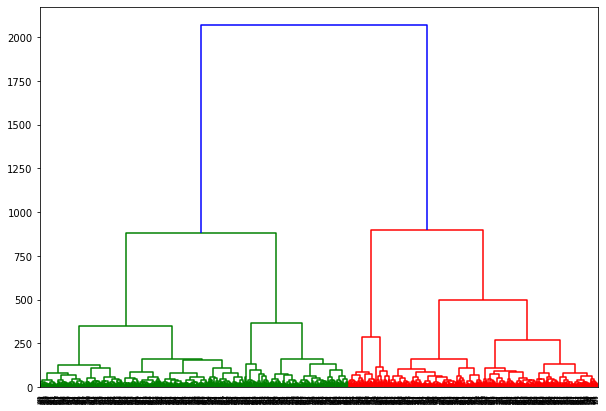

In [55]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(trXtrans, method='ward'))

In [58]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(trXtrans)

array([0, 4, 4, 3, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 3, 1, 4, 1, 4, 1, 2, 0,
       1, 4, 0, 2, 3, 3, 4, 1, 0, 0, 2, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1,
       0, 0, 1, 0, 3, 2, 3, 3, 4, 1, 1, 3, 1, 0, 1, 1, 3, 3, 0, 1, 1, 1,
       2, 1, 4, 3, 1, 0, 2, 1, 2, 3, 3, 3, 2, 1, 4, 4, 0, 0, 1, 3, 4, 4,
       2, 3, 4, 1, 4, 4, 4, 1, 1, 1, 0, 1, 1, 1, 1, 4, 0, 1, 1, 1, 4, 3,
       4, 1, 1, 1, 0, 0, 3, 3, 4, 3, 3, 4, 1, 3, 1, 3, 0, 1, 1, 3, 0, 0,
       3, 0, 4, 1, 1, 4, 4, 3, 3, 3, 0, 3, 0, 3, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 4, 1, 0, 4, 0, 2, 3, 4, 0, 0, 3, 1, 1, 1, 3, 1, 0, 1, 4, 1, 4,
       3, 1, 1, 4, 1, 4, 1, 2, 3, 2, 1, 1, 4, 4, 3, 3, 0, 0, 1, 3, 1, 3,
       1, 2, 4, 1, 0, 1, 4, 4, 3, 1, 4, 3, 4, 3, 4, 4, 0, 0, 1, 4, 4, 2,
       1, 3, 4, 1, 0, 4, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 4, 4, 1, 1, 3, 3,
       1, 1, 1, 1, 0, 3, 0, 3, 0, 2, 4, 1, 0, 3, 3, 4, 1, 1, 1, 1, 0, 4,
       1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 0, 0, 0, 2, 4, 3, 1, 3, 1, 4, 3, 3,
       2, 0, 1, 2, 0, 0, 2, 4, 1, 1, 1, 3, 2, 3, 4,